In [1]:
%matplotlib inline
import cv2
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime
import scipy.stats as stats

### Import dataframe

In [2]:
#Import dataframes
df_metadata = pd.read_excel(r'F:\biodi_project\experiment_data\df_allfish_allexperiments.xlsx')
df_data = pd.read_excel(r'F:\biodi_project\analysis_dlc\video_analysis_network_3points\dataframe_results\df-long_results_5min-analysed_2023-10-25.xlsx')
df_pref_idx = pd.read_excel(r'F:\biodi_project\analysis_dlc\video_analysis_network_3points\dataframe_results\df_pref-index-results_5min-analysed_2023-10-25.xlsx')

In [26]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group']) - {'exp1-flock-random2-speed8', 'expWRONG-exp3-n6-speed12-n6-speed12'}))
fish_ids = list(set(df_data['fish_ID'].values))
exp_date = list(sorted(set(df_data['date'].values)))

### Select subjects to analyse

Choose some criteria and select the fish ID and experiment time, so to include only the selected sujects into the analysis

The main criteria used are: 
- fish that did not visit any choice area during the whole experiment (HAB+TEST) were escluded
- fish that spent 95% of time at HAB and 95% of time at TEST in the same choice area were excluded
- experiments that had problems were excluded
- only fish tested for the first time were included

### Criteria:

0. **Baseline**
    - experiments that had problems were excluded
    - only fish tested for the first time were included
    
1. **Severity1** 
    - Baseline
    - fish that did not visit any choice area during the whole experiment (HAB+TEST) were escluded
    - fish that spent 95% of time at HAB and 95% of time at TEST in the same choice area were excluded
   
   
2. **Severity2** 
    - Severity1
    - More > 90% time spent in the center during TEST
    
    
3. **Severity3**
    - Severity1
    - < 95% on one side during habituation
    

4. **Severity4**
    - Severity1
    - < 90% on one side during habituation
    
    
5. **Severity5** 
    - fish that spent 100% of time near one side at test were excluded
    
    
6. **Severity6** 
    - Severity2 + Severity3
    
    
7. **Severity7** 
    - Severity2 + Severity3 + Severity5

In [23]:
df_metadata['exp_group'].isin(exp_groups)

0      False
1      False
2      False
3      False
4      False
       ...  
390     True
391     True
392     True
393     True
394     True
Name: exp_group, Length: 395, dtype: bool

In [27]:
# BASELINE
baseline = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')) &
            (df_metadata['first_exp'] == 'yes') & (df_metadata['exp_name'] == 'biodi') &
            (df_metadata['session'] == 'TEST') & (df_metadata['exp_group'].isin(exp_groups)))

selected_subj = set(df_metadata.loc[baseline, 'fish_ID'])
selected_dates = set(df_metadata.loc[baseline, 'date'])

baseline_selector_df_data = df_data['fish_ID'].isin(selected_subj) & df_data['date'].isin(selected_dates)
selected_fishIDs_baseline = set(df_data[df_data['fish_ID'].isin(selected_subj)]['fish_ID'])
selected_dates_baseline = set(df_data[df_data['fish_ID'].isin(selected_dates)]['date'])

print('baseline criteria:', len(selected_fishIDs_baseline), '/', len(fish_ids), 'fish')
print('')

for group in exp_groups:
    fish_baseline = df_data[baseline_selector_df_data]
    selected_fish = set(fish_baseline[fish_baseline['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))

baseline criteria: 131 / 171 fish

exp1-flock-random1 :     8
exp1-flock-random2 :     9
exp1-random1-random2 :     9
exp2-n3-speed3-12 :     9
exp2-n3-speed3-6 :     10
exp2-n3-speed6-12 :     8
exp2-n6-speed3-12 :     14
exp2-n6-speed3-6 :     11
exp2-n6-speed6-12 :     9
exp3-n3-speed12-n6-speed6 :     9
exp3-n3-speed6-n6-speed3 :     9
exp3-n3-speed6-n6-speed6 :     17
exp4-realfish-empty :     9


In [7]:
#SEVERITY 1 - 
# fish that did not visit any choice area during the whole experiment (HAB+TEST) were escluded
# fish that spent 95% of time at HAB and 95% of time at TEST in the same choice area were excluded

#if 99% we include fish 164

fish_IDs = set(df_data['fish_ID'])
selected_fish = []

minutes = 5
percent = 95

percent_95_of_5min = minutes*60/100*percent

skip_fish = [59, 90, 91, 92, 102] #fish whose HAB video is missing 

for fish in fish_IDs:
    fish_data = df_data[df_data['fish_ID'] == fish]
    
    if fish_data['tot_sec'].sum() > 0:
        #print(fish)
        
        if fish in skip_fish:
            hab_L_95perc = True
            hab_R_95perc = True
            
        else:
            hab_L_95perc = fish_data[(fish_data['side'] == 'L') &
                                     (fish_data['session'] == 'HAB')]['tot_sec'].values[0] < percent_95_of_5min
            hab_R_95perc = fish_data[(fish_data['side'] == 'R') &
                                     (fish_data['session'] == 'HAB')]['tot_sec'].values[0] < percent_95_of_5min
        
        test_L_95perc = fish_data[(fish_data['side'] == 'L') & 
                                  (fish_data['session'] == 'TEST')]['tot_sec'].values[0] < percent_95_of_5min
        test_R_95perc = fish_data[(fish_data['side'] == 'R') &
                                  (fish_data['session'] == 'TEST')]['tot_sec'].values[0] < percent_95_of_5min

        if (hab_L_95perc or test_L_95perc) and (hab_R_95perc or test_R_95perc):
            selected_fish.append(fish)

severity1_selector_df_data = baseline_selector_df_data & (df_data['fish_ID'].isin(selected_fish))
selected_fishIDs_severity1 = set(df_data.loc[severity1_selector_df_data, 'fish_ID'])
selected_dates_severity1 = set(df_data.loc[severity1_selector_df_data, 'date'])

print('severity1:', len(selected_fishIDs_severity1), '/', len(fish_ids), 'fish')
print('fish removed according to severity1', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity1))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity1)
print('')

for group in exp_groups:
    fish_severity1 = df_data[severity1_selector_df_data]
    selected_fish = set(fish_severity1[fish_severity1['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity1: 141 / 171 fish
fish removed according to severity1 2
fish IDs {164, 84}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     9
selected fish {32, 33, 25, 26, 27, 28, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     8
selected fish {161, 162, 145, 146, 147, 148, 149, 150}

exp2-n6-speed3-12 :     14
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 137, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     9
selected fish {64, 50, 51, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     9
selected fish {73, 74, 75, 76, 77, 78, 79, 80, 81}

In [8]:
# SEVERITY 2 
# Severity 1 + > 90% time spent in the center during TEST 
#if >95% the only 4 instead of 9 fish are removed

fish_IDs = set(df_data['fish_ID'])
selected_fish = []

minutes = 5
percent = 10

percent_10_of_5min = minutes*60/100*percent

for fish in fish_IDs:
    fish_data = df_data[df_data['fish_ID'] == fish]
    
    test_L_tot_time = fish_data[(fish_data['side'] == 'L') & 
                                  (fish_data['session'] == 'TEST')]['tot_sec'].values[0]
    test_R_tot_time = fish_data[(fish_data['side'] == 'R') &
                                  (fish_data['session'] == 'TEST')]['tot_sec'].values[0]
    
    if (test_L_tot_time + test_R_tot_time) > percent_10_of_5min :
        selected_fish.append(fish)

severity2_selector_df_data = severity1_selector_df_data & (df_data['fish_ID'].isin(selected_fish))
selected_fishIDs_severity2 = set(df_data.loc[severity2_selector_df_data, 'fish_ID'])
selected_dates_severity2 = set(df_data.loc[severity2_selector_df_data, 'date'])

print('severity2:', len(selected_fishIDs_severity2), '/', len(fish_ids), 'fish')
print('fish removed according to severity2', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity2))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity2)
print('')

for group in exp_groups:
    fish_severity2 = df_data[severity2_selector_df_data]
    selected_fish = set(fish_severity2[fish_severity2['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity2: 134 / 171 fish
fish removed according to severity2 9
fish IDs {164, 40, 145, 115, 51, 84, 148, 28, 127}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     8
selected fish {32, 33, 25, 26, 27, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     6
selected fish {161, 162, 146, 147, 149, 150}

exp2-n6-speed3-12 :     14
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 137, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     8
selected fish {64, 50, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     9
selected fish {73, 74, 75, 76, 77, 7

In [9]:
# SEVERITY 3
# Severity1 + > 95% on one side during habituation

fish_IDs = set(df_data['fish_ID'])
skip_fish = [59, 90, 91, 92, 102] #fish whose HAB video is missing 

selected_fish = []

minutes = 5
percent = 95
percent_95_of_5min = minutes*60/100*percent

for fish in fish_IDs:
    fish_data = df_data[df_data['fish_ID'] == fish]
    
    if fish in skip_fish:
        selected_fish.append(fish)
    
    else: 
        hab_L_tot_time = fish_data[(fish_data['side'] == 'L') & 
                                      (fish_data['session'] == 'HAB')]['tot_sec'].values[0]
        hab_R_tot_time = fish_data[(fish_data['side'] == 'R') &
                                      (fish_data['session'] == 'HAB')]['tot_sec'].values[0]

        if (hab_L_tot_time < percent_95_of_5min) and (hab_R_tot_time < percent_95_of_5min):
            selected_fish.append(fish)

severity3_selector_df_data = severity1_selector_df_data & (df_data['fish_ID'].isin(selected_fish))
selected_fishIDs_severity3 = set(df_data.loc[severity3_selector_df_data, 'fish_ID'])
selected_dates_severity3 = set(df_data.loc[severity3_selector_df_data, 'date'])
                               
print('severity3:', len(selected_fishIDs_severity3), '/', len(fish_ids), 'fish')
print('fish removed according to severity3', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity3))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity3)
print('')

for group in exp_groups:
    fish_severity3 = df_data[severity3_selector_df_data]
    selected_fish = set(fish_severity3[fish_severity3['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity3: 138 / 171 fish
fish removed according to severity3 5
fish IDs {164, 137, 84, 117, 126}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     9
selected fish {32, 33, 25, 26, 27, 28, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     8
selected fish {161, 162, 145, 146, 147, 148, 149, 150}

exp2-n6-speed3-12 :     13
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     9
selected fish {64, 50, 51, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     9
selected fish {73, 74, 75, 76, 77, 78, 7

In [10]:
# SEVERITY 4
# Severity1 + > 99% on one side during habituation

fish_IDs = set(df_data['fish_ID'])
skip_fish = [59, 90, 91, 92, 102] #fish whose HAB video is missing 

selected_fish = []

minutes = 5
percent = 99
percent_99_of_5min = minutes*60/100*percent

for fish in fish_IDs:
    fish_data = df_data[df_data['fish_ID'] == fish]
    
    if fish in skip_fish:
        selected_fish.append(fish)
    
    else: 
        hab_L_tot_time = fish_data[(fish_data['side'] == 'L') & 
                                      (fish_data['session'] == 'HAB')]['tot_sec'].values[0]
        hab_R_tot_time = fish_data[(fish_data['side'] == 'R') &
                                      (fish_data['session'] == 'HAB')]['tot_sec'].values[0]

        if (hab_L_tot_time < percent_99_of_5min) and (hab_R_tot_time < percent_99_of_5min):
            selected_fish.append(fish)

severity4_selector_df_data = severity1_selector_df_data & (df_data['fish_ID'].isin(selected_fish))
selected_fishIDs_severity4 = set(df_data.loc[severity4_selector_df_data, 'fish_ID'])
selected_dates_severity4 = set(df_data.loc[severity4_selector_df_data, 'date'])

print('severity4:', len(selected_fishIDs_severity4), '/', len(fish_ids), 'fish')
print('fish removed according to severity4', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity4))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity4)
print('')

for group in exp_groups:
    fish_severity4 = df_data[severity4_selector_df_data]
    selected_fish = set(fish_severity4[fish_severity4['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity4: 139 / 171 fish
fish removed according to severity4 4
fish IDs {137, 164, 84, 117}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     9
selected fish {32, 33, 25, 26, 27, 28, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     8
selected fish {161, 162, 145, 146, 147, 148, 149, 150}

exp2-n6-speed3-12 :     13
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     9
selected fish {64, 50, 51, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     9
selected fish {73, 74, 75, 76, 77, 78, 79, 80

In [11]:
# SEVERITY 5
# Severity1 + fish that spent 100% of time near one side at test were excluded

## TODO 100% of total time 

fish_IDs = set(df_data['fish_ID'])

selected_fish = []

minutes = 5
percent = 99
percent_100_of_5min = minutes*60/100*percent

for fish in fish_IDs:
    fish_data = df_data[df_data['fish_ID'] == fish]
 
    test_L_tot_time = fish_data[(fish_data['side'] == 'L') & 
                                      (fish_data['session'] == 'TEST')]['tot_sec'].values[0]
    test_R_tot_time = fish_data[(fish_data['side'] == 'R') &
                                      (fish_data['session'] == 'TEST')]['tot_sec'].values[0]
    
    if (test_L_tot_time < percent_100_of_5min) and (test_R_tot_time < percent_100_of_5min):
        selected_fish.append(fish)

severity5_selector_df_data = severity1_selector_df_data & (df_data['fish_ID'].isin(selected_fish))
selected_fishIDs_severity5 = set(df_data.loc[severity5_selector_df_data, 'fish_ID'])
selected_dates_severity5 = set(df_data.loc[severity5_selector_df_data, 'date'])

print('severity5:', len(selected_fishIDs_severity5), '/', len(fish_ids), 'fish')
print('fish removed according to severity5', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity5))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity5)
print('')

for group in exp_groups:
    fish_severity5 = df_data[severity5_selector_df_data]
    selected_fish = set(fish_severity5[fish_severity5['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity5: 139 / 171 fish
fish removed according to severity5 4
fish IDs {73, 74, 164, 84}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     9
selected fish {32, 33, 25, 26, 27, 28, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     8
selected fish {161, 162, 145, 146, 147, 148, 149, 150}

exp2-n6-speed3-12 :     14
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 137, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     9
selected fish {64, 50, 51, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     7
selected fish {75, 76, 77, 78, 79, 80, 81}

In [12]:
# SEVERITY 6
# Severity1 + Severity2 + Severity3 

fish_IDs = set(df_data['fish_ID'])


severity6_selector_df_data = severity1_selector_df_data & severity2_selector_df_data & severity3_selector_df_data
selected_fishIDs_severity6 = set(df_data.loc[severity6_selector_df_data, 'fish_ID'])
selected_dates_severity6 = set(df_data.loc[severity6_selector_df_data, 'date'])

print('severity6:', len(selected_fishIDs_severity6), '/', len(fish_ids), 'fish')
print('fish removed according to severity6', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity6))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity6)
print('')

for group in exp_groups:
    fish_severity6 = df_data[severity6_selector_df_data]
    selected_fish = set(fish_severity6[fish_severity6['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity6: 131 / 171 fish
fish removed according to severity6 12
fish IDs {164, 40, 137, 145, 115, 51, 84, 117, 148, 28, 126, 127}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     8
selected fish {32, 33, 25, 26, 27, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     6
selected fish {161, 162, 146, 147, 149, 150}

exp2-n6-speed3-12 :     13
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     8
selected fish {64, 50, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     9
selected fish {73, 74, 75

In [13]:
# SEVERITY 7
# Severity1 + Severity2 + Severity3 + Severity5

fish_IDs = set(df_data['fish_ID'])

severity7_selector_df_data = severity1_selector_df_data & severity2_selector_df_data & severity3_selector_df_data & severity5_selector_df_data
selected_fishIDs_severity7 = set(df_data.loc[severity7_selector_df_data, 'fish_ID'])
selected_dates_severity7 = set(df_data.loc[severity7_selector_df_data, 'date'])

print('severity7:', len(selected_fishIDs_severity7), '/', len(fish_ids), 'fish')
print('fish removed according to severity7', len(selected_fishIDs_baseline) - len(selected_fishIDs_severity7))
print('fish IDs', selected_fishIDs_baseline - selected_fishIDs_severity7)
print('')

for group in exp_groups:
    fish_severity7 = df_data[severity7_selector_df_data]
    selected_fish = set(fish_severity7[fish_severity7['exp_group'] == group]['fish_ID'])
    print(group, ':    ', len(selected_fish))
    print('selected fish', selected_fish)
    print('')

severity7: 129 / 171 fish
fish removed according to severity7 14
fish IDs {164, 40, 73, 74, 137, 145, 51, 84, 115, 117, 148, 28, 126, 127}

exp1-flock-random1 :     8
selected fish {34, 35, 10, 11, 12, 13, 14, 15}

exp1-flock-random2 :     8
selected fish {32, 33, 25, 26, 27, 29, 30, 31}

exp1-flock-random2-speed8 :     9
selected fish {1, 2, 3, 4, 5, 6, 7, 8, 9}

exp1-random1-random2 :     9
selected fish {16, 17, 18, 19, 20, 21, 22, 23, 24}

exp2-n3-speed3-12 :     9
selected fish {166, 167, 168, 87, 88, 89, 90, 91, 92}

exp2-n3-speed3-6 :     10
selected fish {160, 142, 143, 144, 151, 152, 153, 154, 158, 159}

exp2-n3-speed6-12 :     6
selected fish {161, 162, 146, 147, 149, 150}

exp2-n6-speed3-12 :     13
selected fish {65, 66, 67, 68, 69, 70, 71, 72, 136, 138, 139, 140, 141}

exp2-n6-speed3-6 :     9
selected fish {163, 165, 82, 83, 85, 86, 155, 156, 157}

exp2-n6-speed6-12 :     8
selected fish {64, 50, 52, 53, 54, 55, 62, 63}

exp3-n3-speed12-n6-speed6 :     7
selected fish {75

# Statistics

### T-test with preference index

In [ ]:
df_pref_stat = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

bool_selector = ((df_pref_stat['fish_ID'].isin(selected_fishIDs_severity7)) & 
                 (df_pref_stat['date'].isin(selected_dates_severity7)) &
                 (df_pref_stat['session'] == 'TEST'))
            
data_selected = df_pref_stat[bool_selector].copy()

In [ ]:
pref_idx_one_asterics = []
pref_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected[data_selected['exp_group'] == group]
    t_test = stats.ttest_1samp(grouped_data['pref_index'], 0.5, nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        pref_idx_two_asterics.append(group)
    elif t_test[1] < 0.05:
        pref_idx_one_asterics.append(group)

In [ ]:
pref_idx_one_asterics = ['exp2-n3-speed3-12', 'exp2-n6-speed6-12', 'exp4-realfish-empty']
pref_idx_two_asterics = 'exp1-flock-random1'

### T-test with total time

In [474]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']
minutes = ['minute1', 'minute2', 'minute3', 'minute4', 'minute5']

bool_selector = ((df_data['fish_ID'].isin(selected_fishIDs_severity7)) & 
                 (df_data['date'].isin(selected_dates_severity7)) &
                 (df_data['session'] == 'TEST'))

data_selected_time = df_data[bool_selector].copy()

In [475]:
tot_time_idx_one_asterics = []
tot_time_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected_time[data_selected_time['exp_group'] == group]
    stimuli = np.unique(grouped_data['stimulus'])

    bool_stim1 = grouped_data['stimulus'] == stimuli[0]
    stimulus1_data = grouped_data[bool_stim1]

    bool_stim2 = grouped_data['stimulus'] == stimuli[1]
    stimulus2_data = grouped_data[bool_stim2]
    
    
    t_test = stats.ttest_rel(stimulus1_data['tot_sec'], stimulus2_data['tot_sec'], nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        tot_time_idx_two_asterics.append(group)

    elif t_test[1] < 0.05:
        tot_time_idx_one_asterics.append(group)

exp1-flock-random1
TtestResult(statistic=-2.425437402943634, pvalue=0.045725726905420774, df=7)
exp1-flock-random2
TtestResult(statistic=0.25053799517847897, pvalue=0.8093658393425397, df=7)
exp1-flock-random2-speed8
TtestResult(statistic=-2.1094420469007913, pvalue=0.06793225831143916, df=8)
exp1-random1-random2
TtestResult(statistic=-0.9414817254679753, pvalue=0.3740142749394594, df=8)
exp2-n3-speed3-12
TtestResult(statistic=3.178810284883095, pvalue=0.013020771122004306, df=8)
exp2-n3-speed3-6
TtestResult(statistic=-2.546812507040904, pvalue=0.03135831126427355, df=9)
exp2-n3-speed6-12
TtestResult(statistic=2.1210276609653778, pvalue=0.08739171111825468, df=5)
exp2-n6-speed3-12
TtestResult(statistic=2.093066654518017, pvalue=0.05825750229742441, df=12)
exp2-n6-speed3-6
TtestResult(statistic=0.11306541172458111, pvalue=0.9127644818230747, df=8)
exp2-n6-speed6-12
TtestResult(statistic=2.519850175948755, pvalue=0.03981925880366799, df=7)
exp3-n3-speed12-n6-speed6
TtestResult(statistic=

In [480]:
round(t_test[1],3)

0.092

# Plots

#### Palette dictionary

In [13]:
#Palettes 

pubu = sns.color_palette('PuBu', 10)
blues = sns.color_palette(palette='Blues')
greens = sns.color_palette('Greens', 10)
greens_d = sns.color_palette(palette='Greens_d')
orgs = sns.color_palette(palette='Oranges')
y_orgs = sns.color_palette("YlOrBr")
purples = sns.color_palette(palette='Purples')
rpu = sns.color_palette(palette='RdPu')
prd = sns.color_palette(palette='PuRd')
grey = sns.color_palette(palette='Greys')

stimulus_colors = {
    'random1-n6-speed6': rpu[5],
    'random2-n6-speed6': prd[1], #tab20
    'random2-n6-speed8': purples[1],
    'flock-n6-speed8' : purples[5],
    
    'flock-n3-speed3' : blues[1],
    'flock-n3-speed6' : pubu[5],
    'flock-n3-speed12' : pubu[9],
    
    'flock-n6-speed3' : greens[3],
    'flock-n6-speed6' : greens[7],
    'flock-n6-speed12' : greens_d[5],
    
    'zebragroup-6wpf' : y_orgs[2],
    'empty-tank' : orgs[4]
}

exp_colors = {
    'exp1-flock-random1': rpu[5],
    'exp1-flock-random2': rpu[5],
    'exp1-random1-random2': rpu[5],                              
    'exp1-flock-random2-speed8': purples[5],
    
    'exp2-n6-speed3-12': greens_d[5],
    'exp2-n6-speed3-6': greens_d[5],
    'exp2-n6-speed6-12': greens_d[5],
    
    'exp2-n3-speed3-12' : pubu[5],
    
    'flock-n6-speed3' : greens[1],
    'flock-n6-speed6' : greens[3],
    'flock-n6-speed12' : greens_d[5],
    
     'exp3-n3-speed12-n6-speed6': grey[3],
     'exp3-n3-speed6-n6-speed3': grey[3],
     'exp3-n3-speed6-n6-speed6': grey[3],
     'exp4-realfish-empty': orgs[5],
     'expWRONG-exp3-n6-speed12-n6-speed12': grey[1]
}

### 1. Total time spent near each stimulus

Dictionary for labels 

In [14]:
label_dict = {'empty-tank':'Empty tank', 'zebragroup-6wpf': '6 zebrafish', 
              'random2-n6-speed8' : 'Random 2', 'random1-n6-speed8' : 'Random 1',
              'random2-n6-speed6' : 'Random 2', 'random1-n6-speed6' : 'Random 1', 
              'flock-n3-speed12' : 'Speed 3 cm/s', 'flock-n3-speed3' : 'Speed 0.75 cm/s',
              'flock-n6-speed12' : 'Speed 3 cm/s', 'flock-n6-speed3' : 'Speed 0.75 cm/s',
              'flock-n6-speed8': 'Shoal', 'flock-n6-speed6': 'Speed 1.5 cm/s', 
              'flock-n3-speed6': '3 dots speed 1.5 cm/s'}

#### Boxplots

In [16]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\figures\{folder_name}\boxplots")
folder_path.mkdir(parents=True, exist_ok=True)

exp1-flock-random1
fish 0 :x [-0.18067886342911943, 0.19999999999999996] y [12.73333333333333, 50.0]
fish 1 :x [-0.20000000000000004, 0.19999999999999996] y [121.8666666666667, 150.9333333333333]
fish 2 :x [-0.20000000000000004, 0.18236733606556543] y [19.73333333333333, 153.3666666666666]
fish 3 :x [-0.20000000000000004, 0.19999999999999996] y [64.93333333333334, 83.3]
fish 4 :x [-0.20000000000000004, 0.19999999999999996] y [41.26666666666667, 99.00000000000001]
fish 5 :x [-0.219956234047961, 0.19999999999999996] y [1.233333333333333, 34.1]
fish 6 :x [-0.20000000000000004, 0.19999999999999996] y [11.06666666666667, 22.1]
fish 7 :x [-0.20000000000000004, 0.19999999999999996] y [0.0, 257.5666666666667]
____
exp1-flock-random2
fish 0 :x [-0.20000000000000004, 0.19999999999999996] y [26.56666666666667, 73.46666666666667]
fish 1 :x [-0.19883804916530073, 0.19999999999999996] y [40.46666666666668, 120.4]
fish 2 :x [-0.20000000000000004, 0.19999999999999996] y [36.23333333333333, 32.76666666

exp3-n3-speed6-n6-speed3
fish 0 :x [-0.21421797985512436, 0.18173792254210114] y [92.56666666666666, 92.53333333333333]
fish 1 :x [-0.20000000000000004, 0.19999999999999996] y [89.63333333333334, 90.63333333333334]
fish 2 :x [-0.20000000000000004, 0.19999999999999996] y [33.26666666666667, 19.36666666666667]
fish 3 :x [-0.20000000000000004, 0.19999999999999996] y [70.66666666666666, 42.4]
fish 4 :x [-0.18388604064771957, 0.19999999999999996] y [92.16666666666666, 46.56666666666666]
fish 5 :x [-0.20000000000000004, 0.19999999999999996] y [83.46666666666668, 82.76666666666667]
fish 6 :x [-0.20000000000000004, 0.19999999999999996] y [229.7, 5.933333333333334]
____
exp3-n3-speed6-n6-speed6
fish 0 :x [-0.20000000000000004, 0.18198531958792724] y [120.2333333333333, 68.13333333333333]
fish 1 :x [-0.21792215341459434, 0.19999999999999996] y [61.03333333333334, 72.13333333333333]
fish 2 :x [-0.20000000000000004, 0.19999999999999996] y [26.66666666666667, 7.233333333333333]
fish 3 :x [-0.218688

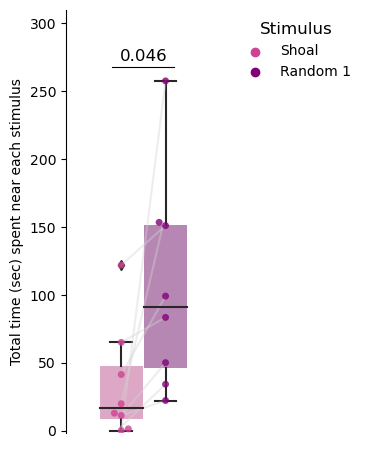

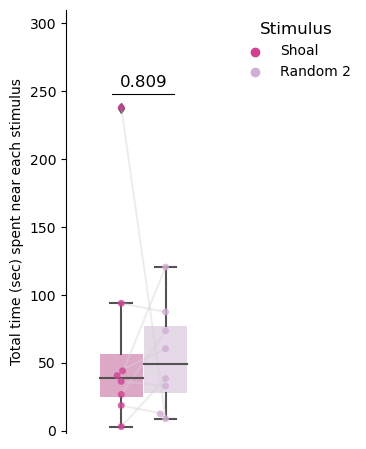

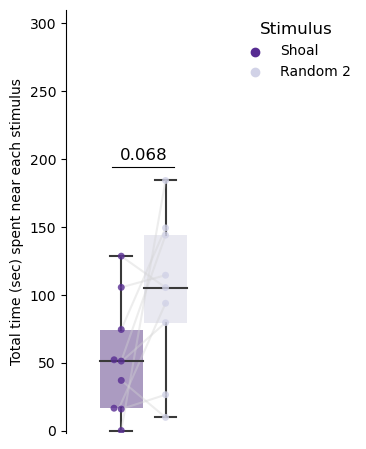

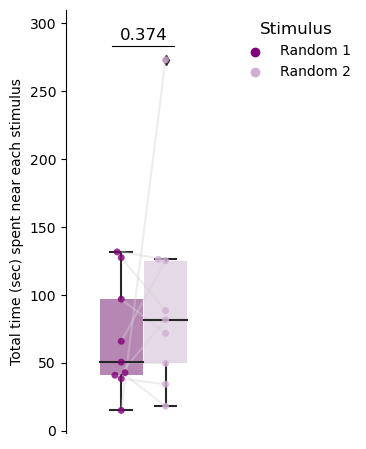

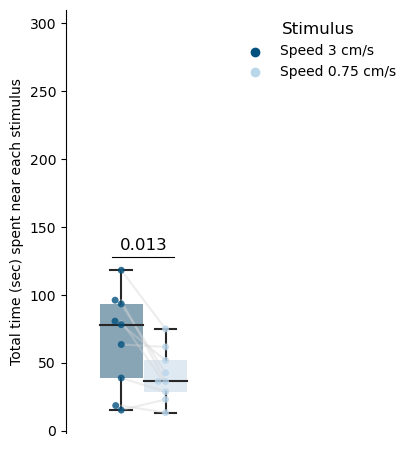

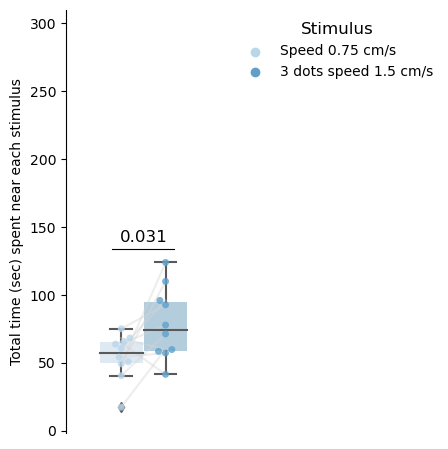

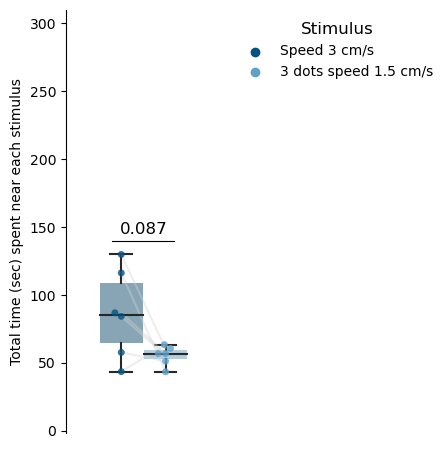

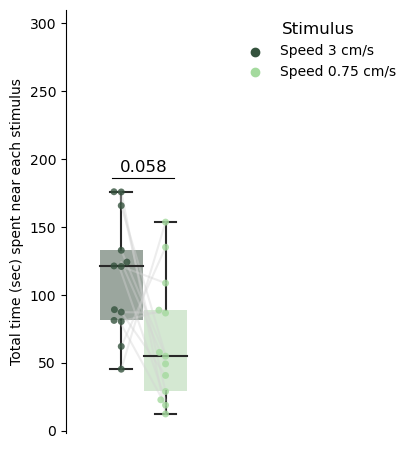

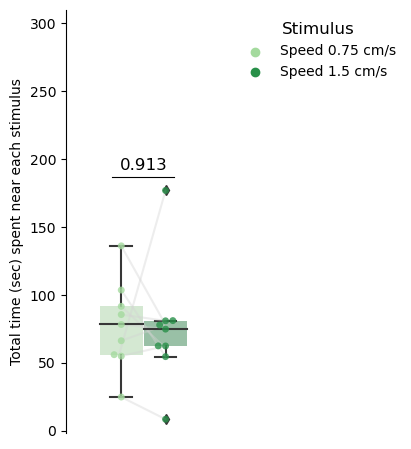

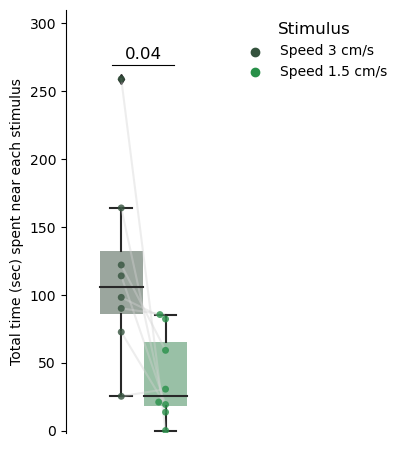

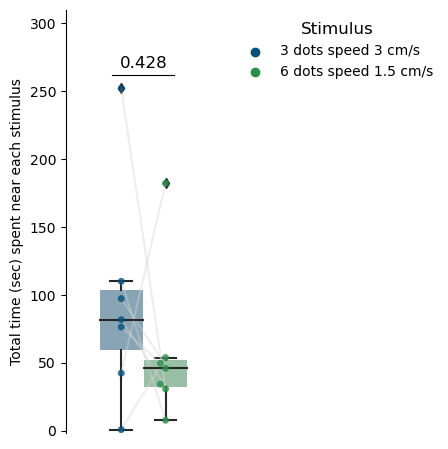

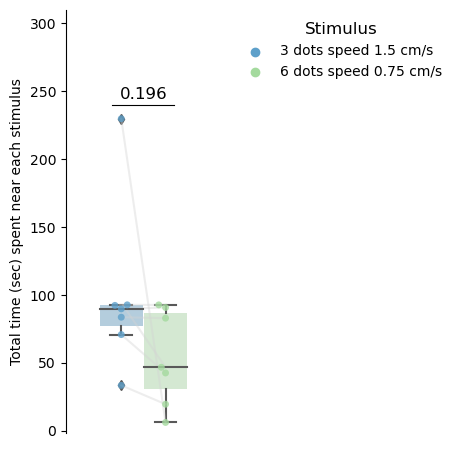

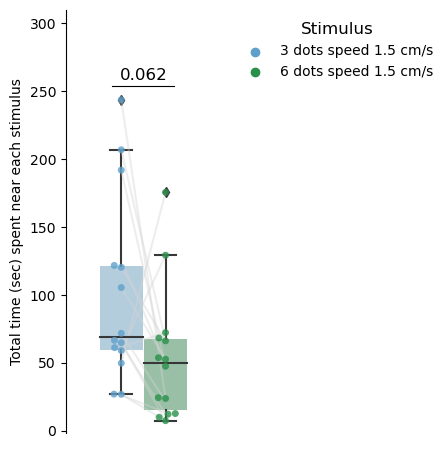

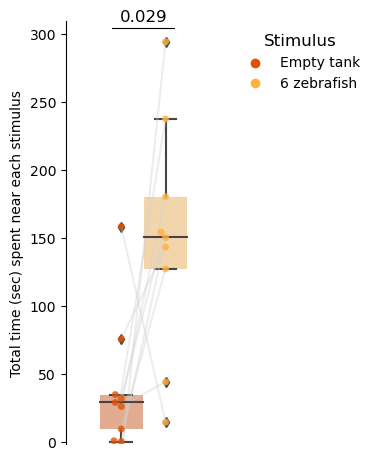

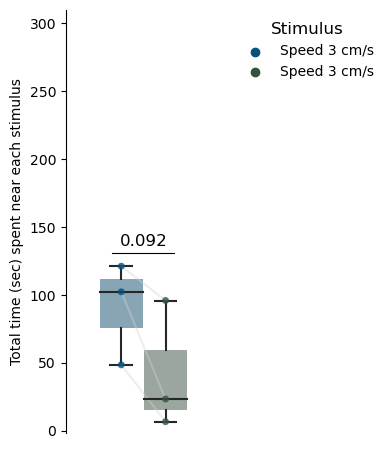

In [17]:
# Loop attraverso ciascun valore in exp_groups
# Specify the parent directory where you want to create the folder
# Get the current date

numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']

for i, group in enumerate(exp_groups):
    # Set colors for stimuli based on the group
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
    
    # Define a boolean selector to filter the data
    bool_selector = ((df_data['fish_ID'].isin(selected_fishIDs_severity7)) & 
                     (df_data['date'].isin(selected_dates_severity7)) &
                     (df_data['exp_group'] == exp_groups[i]) & 
                     (df_data['session'] == 'TEST'))
    
    # Select data based on the boolean selector
    exp_tot_time = df_data[bool_selector]
    
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(2, 5.5))
    
    # Create the swarm plot
    swarmplot = sns.swarmplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                              alpha=0.8, palette=stimulus_colors)
    
    # Create the boxplot with filled boxes and no edges
    boxplot = sns.boxplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                          palette=stimulus_colors, boxprops={'edgecolor': 'None', 'alpha' : 0.5})
    #linewidth=0, showcaps=False, boxprops=dict(alpha=0.6)
    
    
    ''' ADD LINES TO CONNECT DOTS '''
    # Accessing individual dot positions
    x_positions = []
    y_positions = []

    # Iterate through the swarmplot collections to get dot positions
    for collection in swarmplot.collections:
        offsets = collection.get_offsets()
        x_positions.extend(offsets[:, 0])
        y_positions.extend(offsets[:, 1])


    #for fish_id in exp_tot_time['fish_ID'].unique():
        #stim1_y = exp_tot_time[(exp_tot_time['stimulus'] == stimuli_values[0]) & (exp_tot_time['fish_ID'] == fish_id)]['tot_sec'].values[0]
        #stim2_y = exp_tot_time[(exp_tot_time['stimulus'] == stimuli_values[1]) & (exp_tot_time['fish_ID'] == fish_id)]['tot_sec'].values[0]
    
    n_fish = len(exp_tot_time['fish_ID'].unique())
    
    print(group)
    for d in range(n_fish):
        plt.plot([x_positions[d], x_positions[d+n_fish]], [y_positions[d], y_positions[d+n_fish]], color='lightgray',
                alpha=0.4)
        
       
        print('fish', d, ':x', [x_positions[d], x_positions[d+n_fish]], 'y', [y_positions[d], y_positions[d+n_fish]])
    print('____')
    
    
    ''' ADD P-Values '''
    
    stimuli_values = exp_tot_time['stimulus'].unique()
    
    # Select data for each stimulus
    bool_stim1 = exp_tot_time['stimulus'] == stimuli_values[0]
    stimulus1_data = exp_tot_time[bool_stim1]

    bool_stim2 = exp_tot_time['stimulus'] == stimuli_values[1]
    stimulus2_data = exp_tot_time[bool_stim2]
    
    # Perform a paired t-test and round the p-value
    t_test = stats.ttest_rel(stimulus1_data['tot_sec'], stimulus2_data['tot_sec'], nan_policy = 'omit')
    pvalue = round(t_test[1],3)
    
    # Set coordinates for the p-value annotation
    y_coord = np.max(exp_tot_time['tot_sec']) + 10
    x_coord = 0   # Adjust this value as needed to position the line in the center of two boxplots

    # Add a horizontal line to indicate the COMPARISON
    plt.axhline(y=y_coord, xmin=0.3, xmax = 0.7, color='k', linewidth=0.8)
    
    # Annotate the p-value
    plt.annotate(f'{pvalue}', xy=(x_coord, y_coord + 5), fontsize=12, ha='center')
    
           
    ''' Customize legend and appearance ''' 
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a legend based on the experimental group
    legends = []
    exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
    exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
    for label in labels:
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
        legends.append(label_dict[label])
        
    # Create and customize the legend
    legend = ax.legend(handles[:2], legends[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus", prop={'size':12})
    
    # Remove unnecessary spines at the bottom of the plot
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel=None, ylabel="Total time (sec) spent near each stimulus", 
           title=None)
    
    # Modify the x-axis to remove ticks and labels
    ax.xaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    
    # Set the y-axis limits
    plt.ylim(-2, 310)

    # Save the figure as a PDF file
    file_name = folder_path / f"boxplot_{exp_groups[i]}.png"
    #plt.savefig(file_name, bbox_inches='tight')

#### Barplots

In [20]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\barplots")
folder_path.mkdir(parents=True, exist_ok=True)

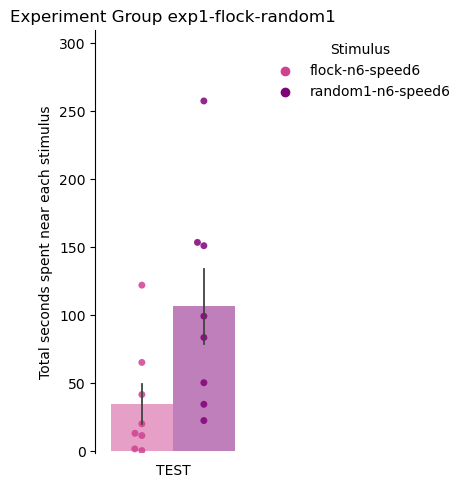

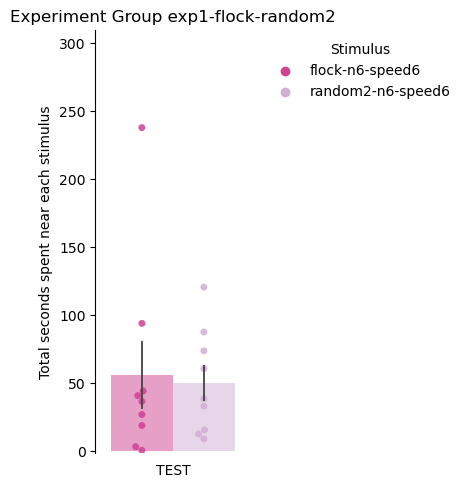

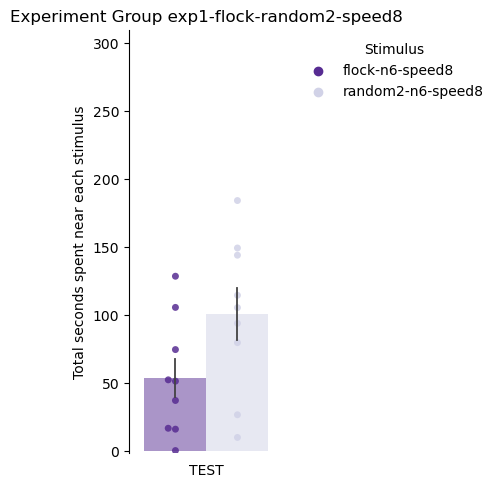

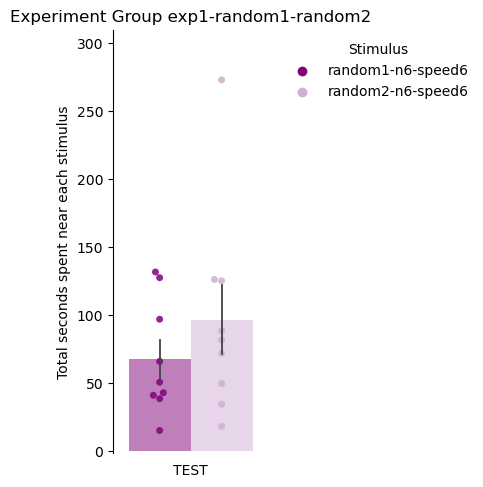

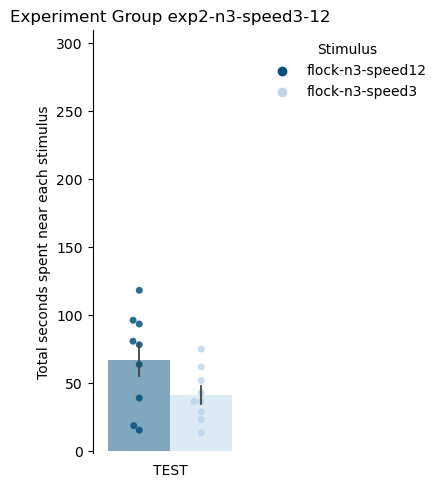

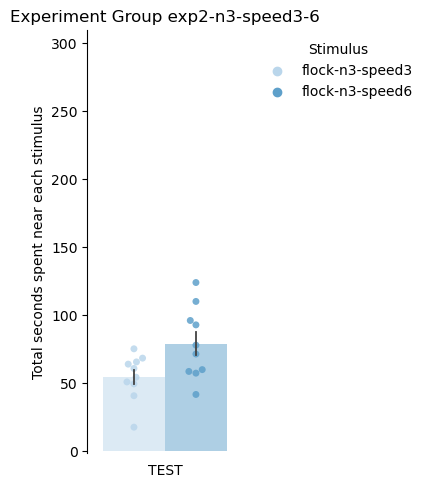

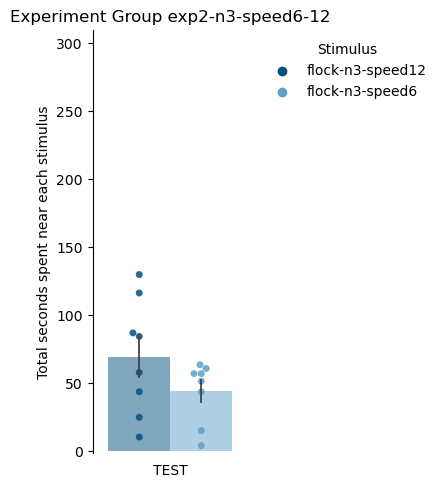

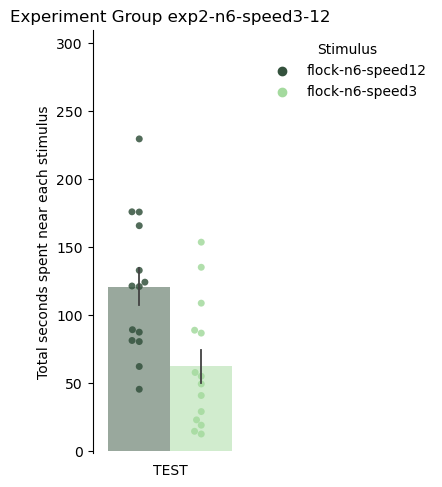

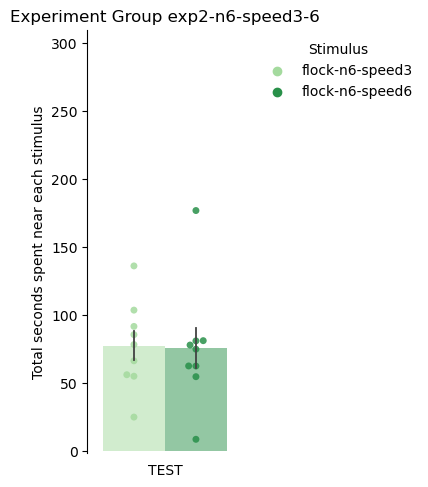

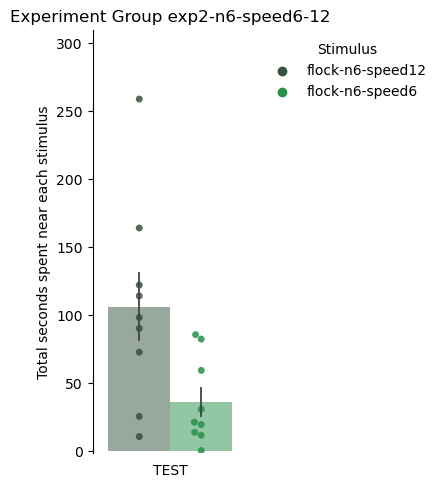

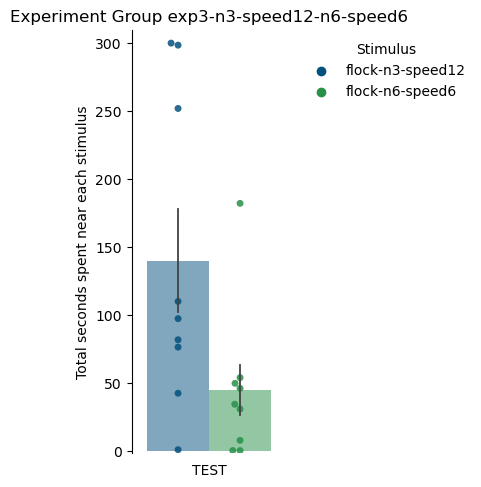

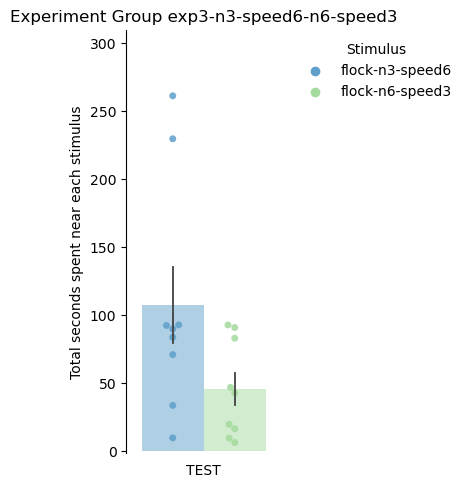

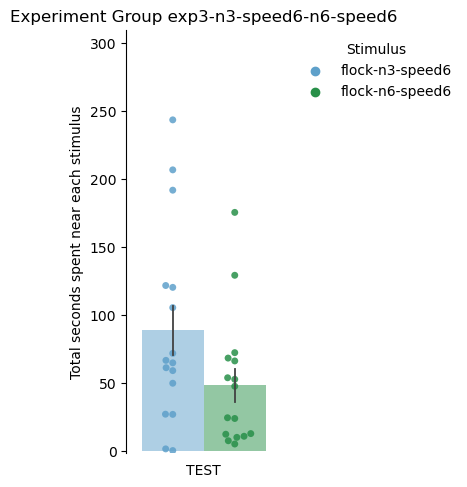

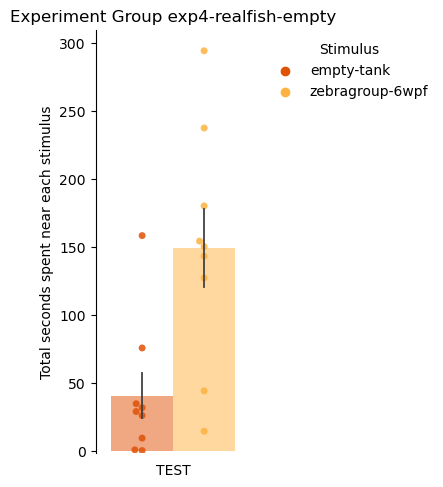

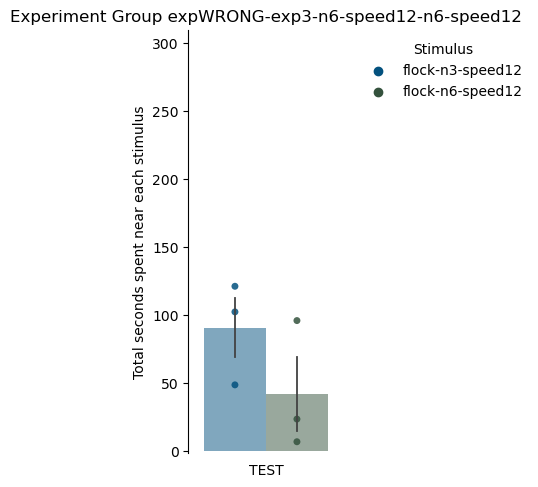

In [21]:
for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
        
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) &
                     (df_data['session'] == 'TEST'))
    
    exp_tot_time = df_data[bool_selector]
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(2, 5.5))
    
    # Create the swarm plot
    swarmplot = sns.swarmplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                              alpha=0.85, palette=stimulus_colors, zorder= -100)
    
    # Create the bar plot with custom edge colors
    barplot = sns.barplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", errorbar="se", 
                          dodge=True, capsize=0, errwidth=1.3, linewidth= 1.5, palette=stimulus_colors, alpha = 0.5)
    
    # Customize bar edge colors and face color
    for bars in ax.containers:
        stimulus = bars.get_label()  # Get the nationality from the container label
        for bar in bars:
            bar.set_edgecolor('None'), 
            bar.set_facecolor(stimulus_colors[stimulus])
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus")
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel=None, ylabel="Total seconds spent near each stimulus", 
           title=f"Experiment Group {exp_groups[i]}")
    ax.xaxis.set_ticks_position('none')
    
    plt.ylim(-2, 310)
    #plt.tight_layout()
    
    # Save the figure as a PDF file
    file_name = folder_path / f"barplot_{group}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')

#### Time points - time spent near each stimulus across minutes

In [ ]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\timepoints_minutes")
folder_path.mkdir(parents=True, exist_ok=True)

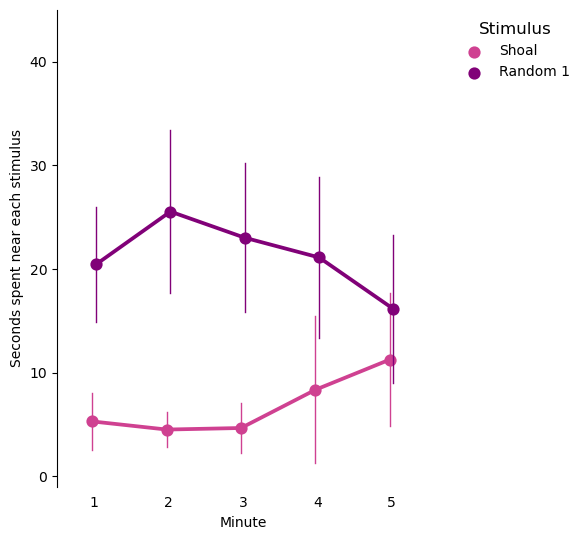

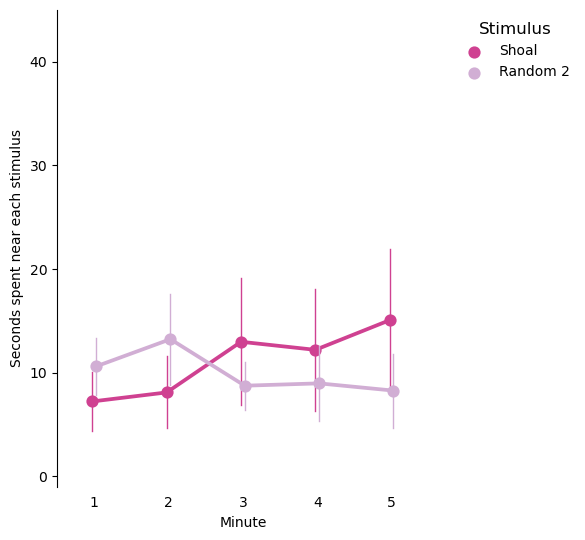

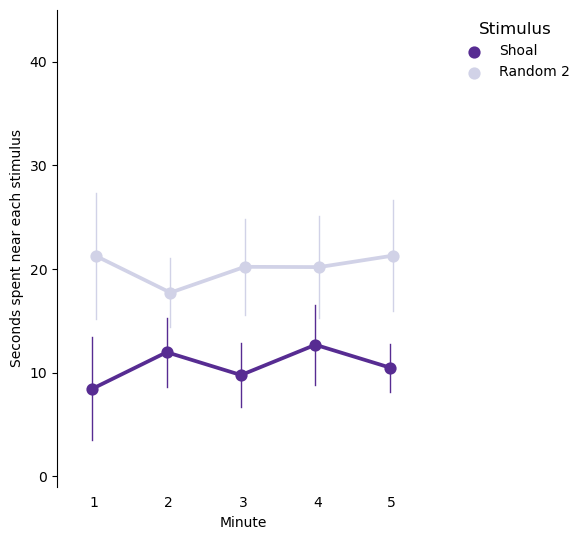

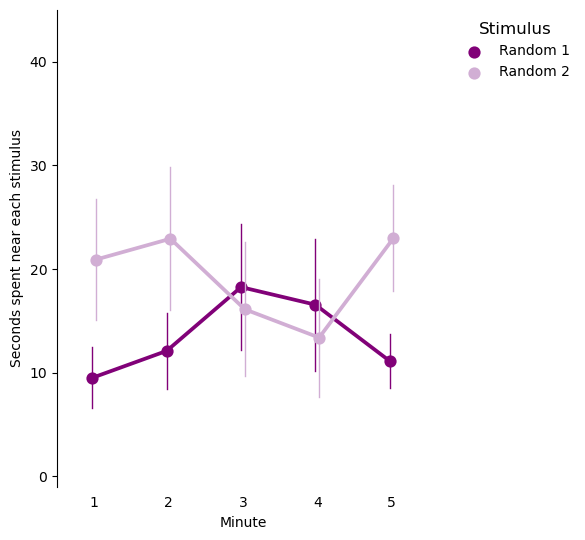

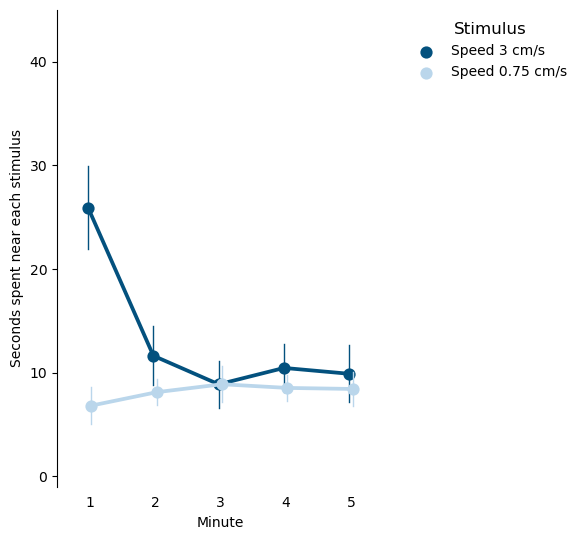

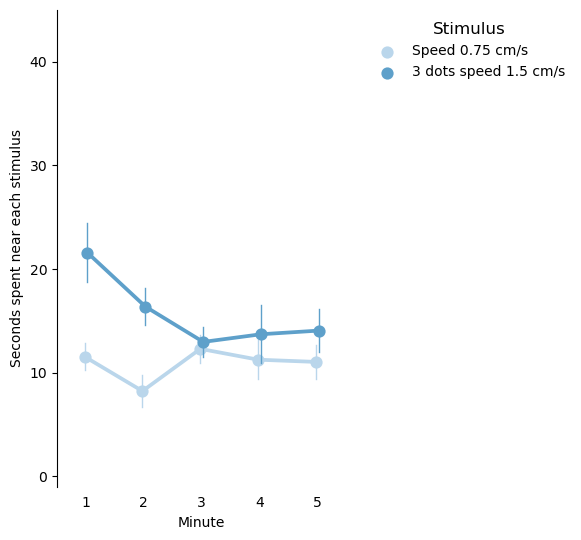

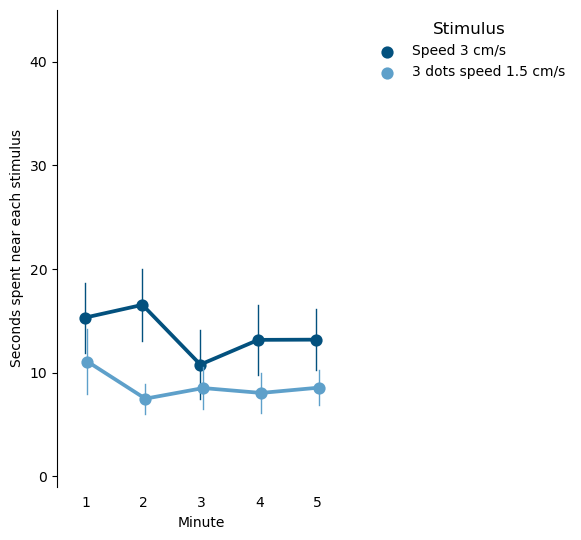

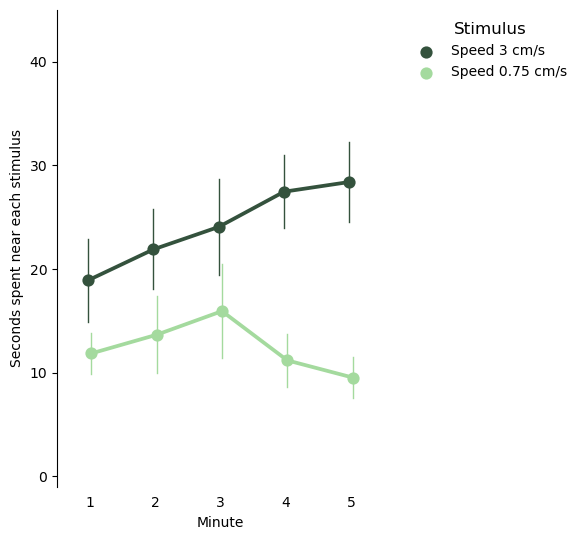

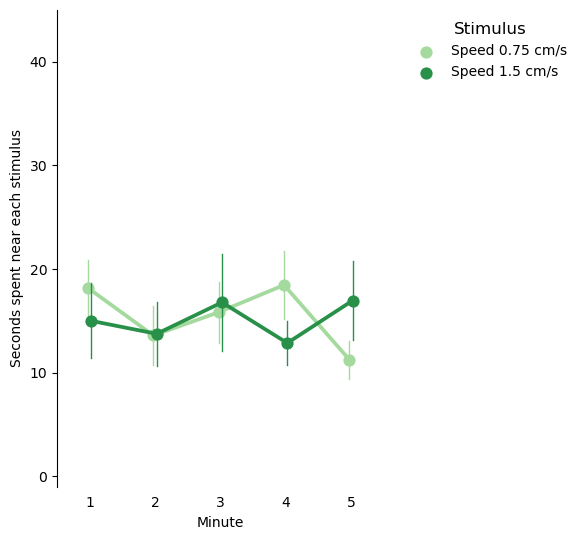

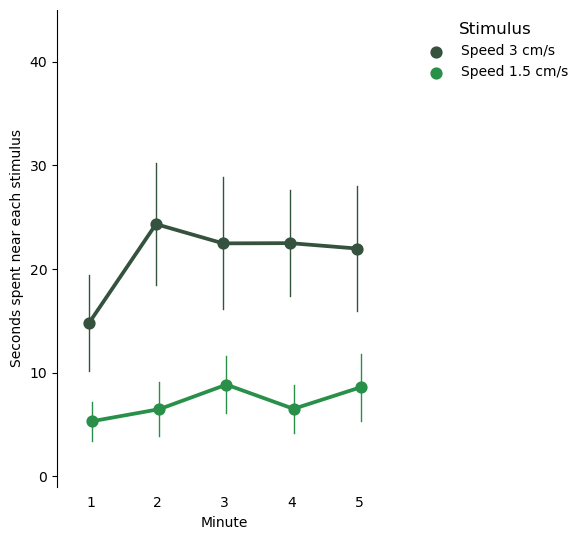

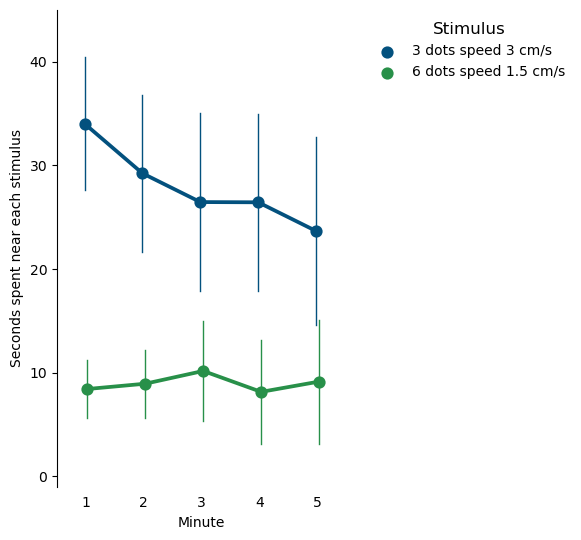

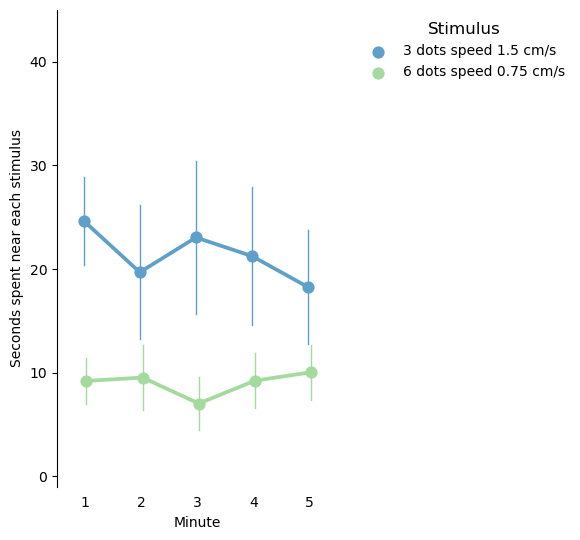

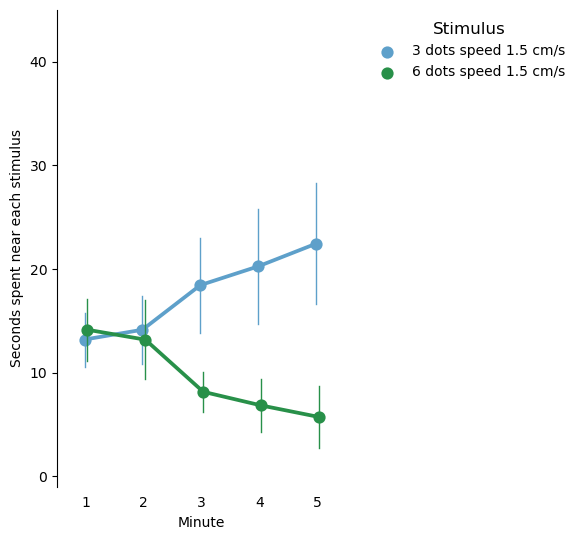

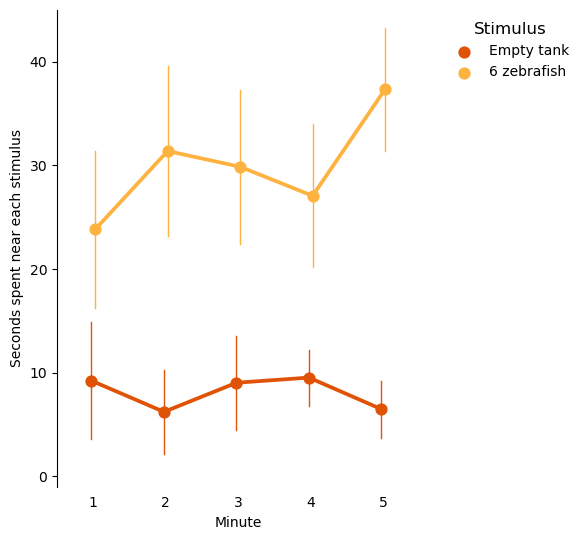

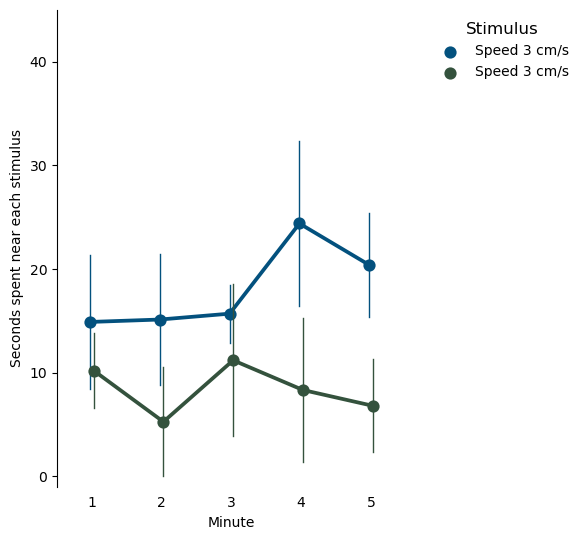

In [22]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']

for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
       
    #Select data 
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) &
                     (df_data['session'] == 'TEST'))
    
    
    df_minutes = df_data[bool_selector]
    
    #Create a long format dataset
    df_long = pd.melt(df_minutes, id_vars=['exp_ID', 'date', 'exp_group', 'session', 'fish_ID', 'side', 'stimulus'], 
                  value_vars=['tot_sec','minute1', 'minute2', 'minute3', 'minute4', 'minute5'], var_name='timepoint')
    
    df_long = df_long.sort_values(['fish_ID', 'timepoint'])
    df_long = df_long[df_long['timepoint'] != 'tot_sec']
    mapping = {'minute1':1, 'minute2':2, 'minute3':3, 'minute4':4, 'minute5':5}
    df_long['timepoint'] = df_long['timepoint'].replace(mapping)
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(6, 5.5))
    
    sns.pointplot(data=df_long, x="timepoint", y="value", hue="stimulus", errorbar="se", 
                  palette=stimulus_colors, dodge=True, join=True, errwidth=1, capsize=0)
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    
    legends = []
    exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
    exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
    for label in labels:
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
        legends.append(label_dict[label])
    
    legend = ax.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus", prop={'size':12})
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel="Minute", ylabel="Seconds spent near each stimulus")
    ax.set_title(None)
    ax.xaxis.set_ticks_position('none')
    
    plt.ylim(-1, 45)
    plt.tight_layout()
    
    #plt.show()
    
    # Save the figure as a PDF file
    file_name = folder_path / f"timepoints_minutes_{group}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')


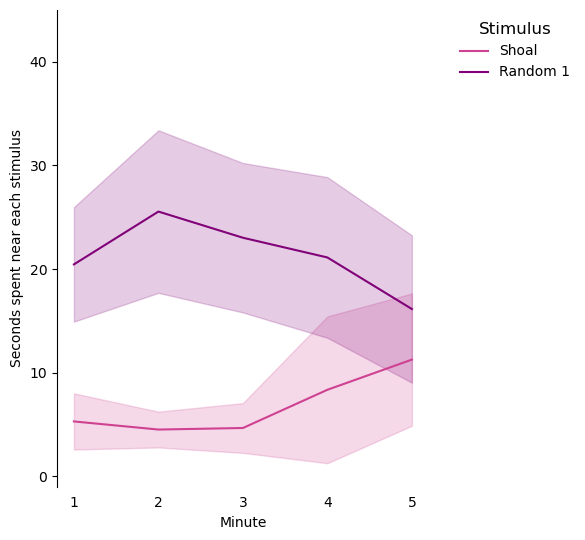

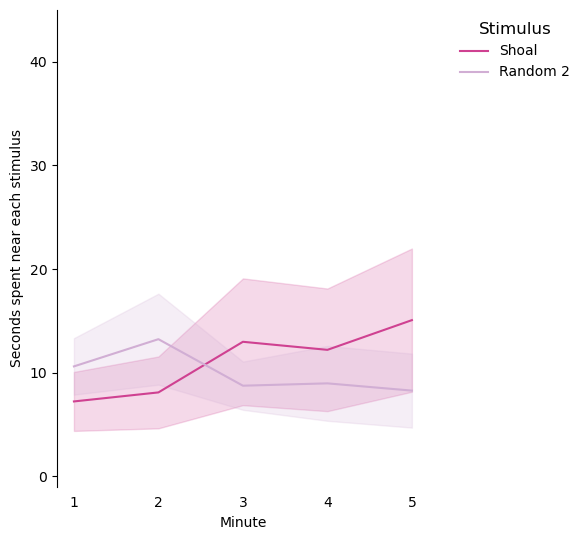

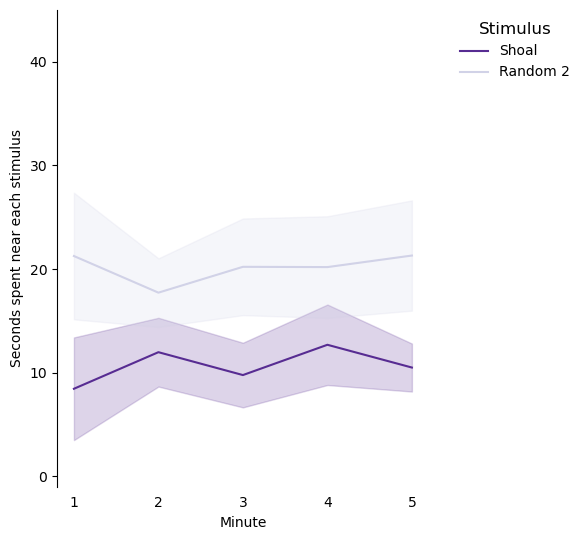

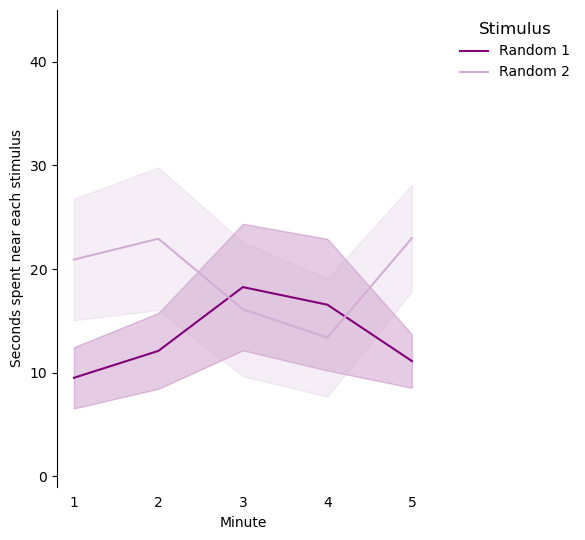

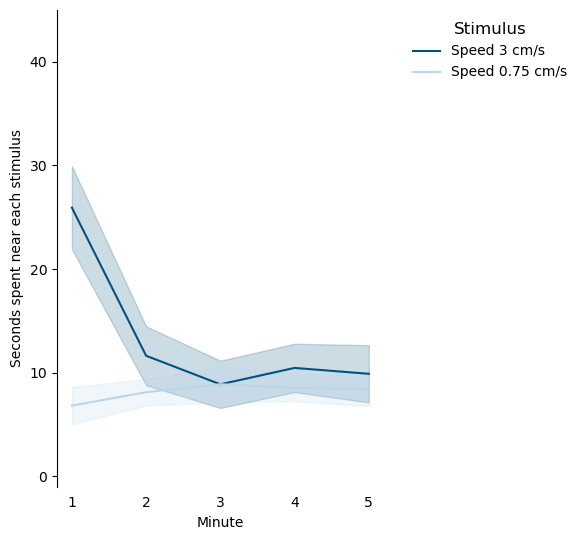

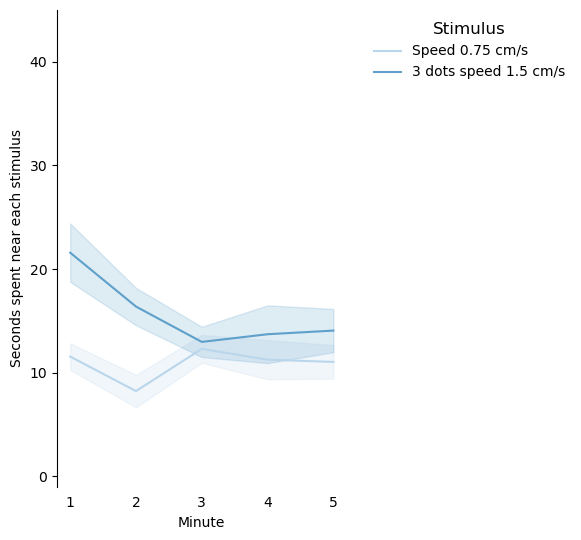

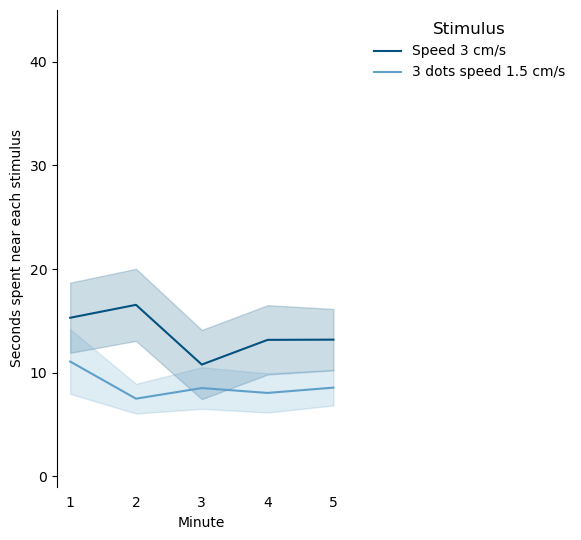

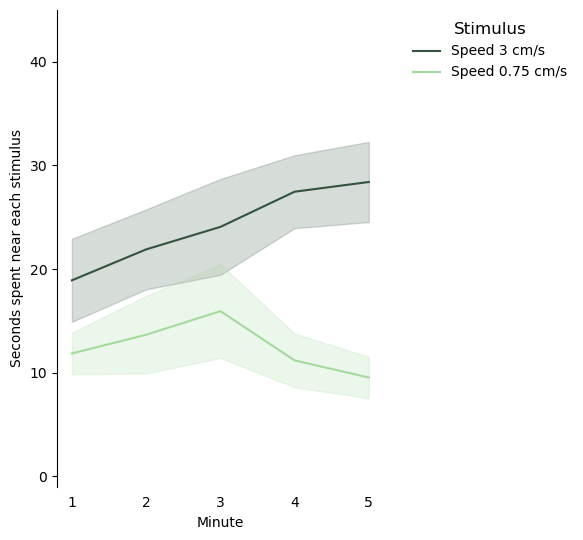

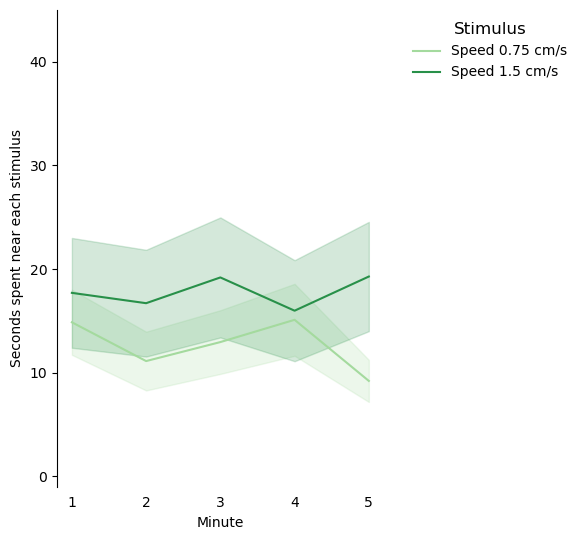

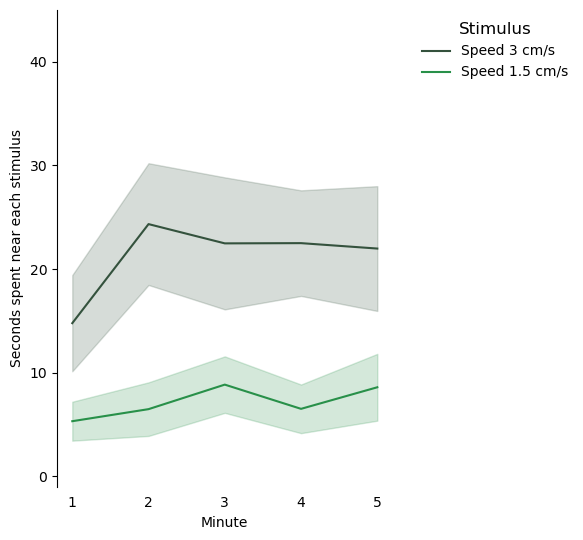

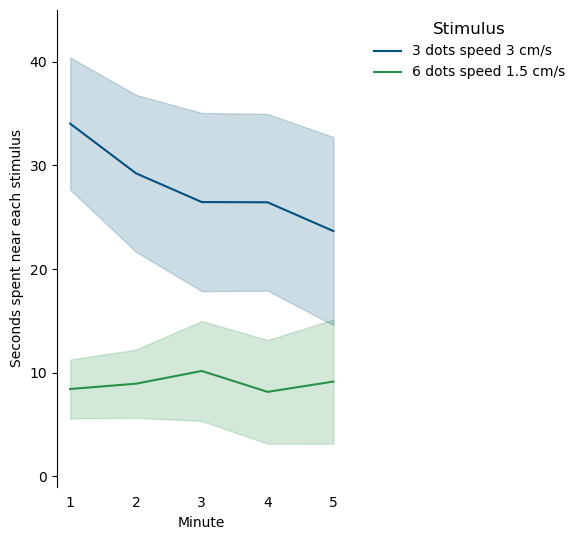

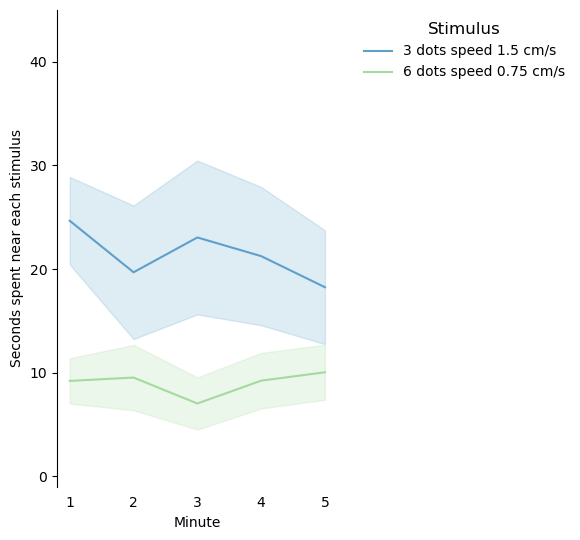

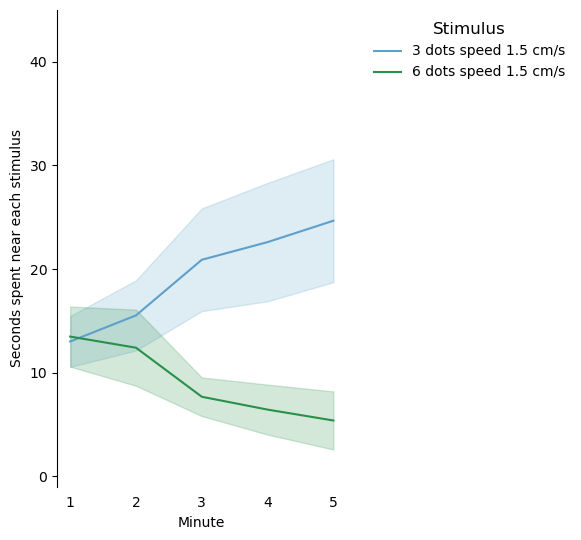

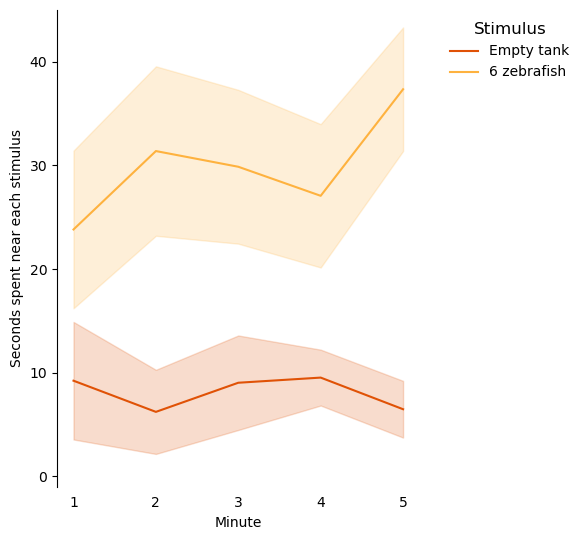

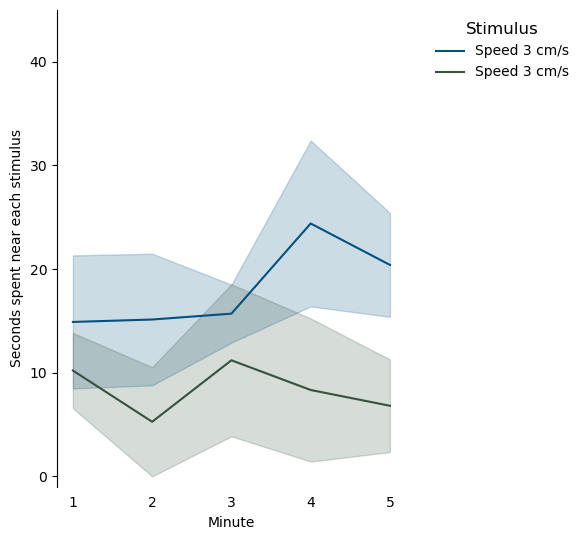

In [488]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']

for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
       
    #Select data 
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) &
                     (df_data['session'] == 'TEST'))
    
    
    df_minutes = df_data[bool_selector]
    
    #Create a long format dataset
    df_long = pd.melt(df_minutes, id_vars=['exp_ID', 'date', 'exp_group', 'session', 'fish_ID', 'side', 'stimulus'], 
                  value_vars=['tot_sec','minute1', 'minute2', 'minute3', 'minute4', 'minute5'], var_name='timepoint')
    
    df_long = df_long.sort_values(['fish_ID', 'timepoint'])
    df_long = df_long[df_long['timepoint'] != 'tot_sec']
    mapping = {'minute1':1, 'minute2':2, 'minute3':3, 'minute4':4, 'minute5':5}
    df_long['timepoint'] = df_long['timepoint'].replace(mapping)
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(6, 5.5))
    
    sns.lineplot(data=df_long, x="timepoint", y="value", hue="stimulus", errorbar=('se'), 
                  palette=stimulus_colors)
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    
    legends = []
    exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
    exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
    for label in labels:
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
        legends.append(label_dict[label])
    
    legend = ax.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus", prop={'size':12})
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel="Minute", ylabel="Seconds spent near each stimulus")
    ax.set_title(None)
    ax.xaxis.set_ticks_position('none')
    
    plt.ylim(-1, 45)
    plt.tight_layout()
    
    #plt.show()
    
    # Save the figure as a PDF file
    file_name = folder_path / f"timepoints_minutes_{group}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')


#### Preference index

In [18]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\figures\{folder_name}\pref_idx")
folder_path.mkdir(parents=True, exist_ok=True)

In [88]:
df_pref_idx_totsec = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

for group in exp_groups:
        bool_selector = ((df_pref_idx_totsec['fish_ID'].isin(selected_subj)) & 
                         (df_pref_idx_totsec['exp_group'] == group) &
                         (df_pref_idx_totsec['date'].isin(selected_dates)) &
                         (df_pref_idx_totsec['session'] == 'TEST'))
            
        data_selected = df_pref_idx_totsec[bool_selector]
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(2, 5.5))

        sns.swarmplot(data=data_selected, y="pref_index", alpha=0.85, 
                                  zorder=-100, dodge=False, color='grey')


                # Create the bar plot with custom edge colors
        sns.pointplot(data=data_selected, y="pref_index", estimator='mean',
                                  errorbar="se", capsize=0, errwidth=1.1, dodge=False, color='black')
        
        # Customize the legend
        #handles, labels = ax.get_legend_handles_labels()
        #legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        sns.despine(bottom=True)
        
        
        ''' ADD P-Values '''

        # Perform a paired t-test and round the p-value
        t_test = stats.ttest_1samp(data_selected['pref_index'], 0.5, nan_policy = 'omit')
        pvalue = round(t_test[1],3)
        
        y_coord = 1
        x_coord = 0   # Adjust this value as needed to position the line in the center of two boxplots

        # Annotate the p-value
        plt.annotate(f'{pvalue}', xy=(x_coord, y_coord), fontsize=12, ha='center')
        
        # Draw a horizontal line at y = 0.5
        ax.axhline(y=0.5, color='red', linestyle='--', label='Threshold')

        # Set labels and title
        ax.set(ylabel="Preference Index", title=f"Experiment group {group}")
        
        # Set y-axis label position to top
        
        exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
        exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n3-speed6'] = 'Speed 1.5 cm/s'
        
        stim1 = label_dict[data_selected["stim1"].values[0]]
        stim2 = label_dict[data_selected["stim2"].values[0]]
        
        if group in exp1:
            x_text = -0.8
        else:
            x_text = -1.1
                
        ax.text(x_text, 1.07, f'{stim1}', fontsize=9.3, fontstyle='italic')
        ax.text(x_text, -0.07, f'{stim2}', fontsize=9.3, fontstyle='italic')
        ax.set_title(None)

        # Set custom y-axis tick labels
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-0.01, 1.01)
        
        file_name = folder_path / f"pref-idx_{group}.png"
        #plt.savefig(file_name, bbox_inches='tight')

#### Preference index across time

In [ ]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\pref_idx\timepoints")
folder_path.mkdir(parents=True, exist_ok=True)


df_pref_idx_min = df_pref_idx.copy()
df_pref_idx_min = df_pref_idx_min[df_pref_idx_min['timepoint'] != 'tot_sec']

In [ ]:
mapping = {'minute1':1, 'minute2':2, 'minute3':3, 'minute4':4, 'minute5':5}
df_pref_idx_min['timepoint'] = df_pref_idx_min['timepoint'].replace(mapping)

for i, group in enumerate(exp_groups):
       
    #Select data 
    bool_selector = ((df_pref_idx_min['fish_ID'].isin(selected_subj)) & 
                     (df_pref_idx_min['date'].isin(selected_dates)) &
                     (df_pref_idx_min['exp_group'] == exp_groups[i]) &
                     (df_pref_idx_min['session'] == 'TEST'))
    
    
    df_pref_min = df_pref_idx_min[bool_selector]
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(6, 5.5))
    
    sns.pointplot(data=df_pref_min, x="timepoint", y="pref_index", estimator='mean', errorbar="se", 
                  capsize=0, errwidth=1, dodge=False, color='black')
    
    sns.swarmplot(data=df_pref_min, x="timepoint", y="pref_index", alpha=0.6, 
                                  zorder=-100, dodge=False, color='grey')

    
    sns.despine(bottom=True)

    # Draw a horizontal line at y = 0.5
    ax.axhline(y=0.5, color='red', linestyle='--', label='Threshold')

                # Set labels and title
    ax.set(xlabel= 'Minute', ylabel="Preference Index")
    
    # Set y-axis label position to top
    ax.text(-1.7, 1.07, f'{df_pref_min["stim1"].values[0]}', fontsize=9.3, fontstyle='italic')
    ax.text(-1.7, -0.08, f'{df_pref_min["stim2"].values[0]}', fontsize=9.3, fontstyle='italic')
    ax.set_title(f"Experiment group {group}", y=1.11, fontsize=10.5)

    # Set custom y-axis tick labels
    ax.xaxis.set_ticks_position('none')
    plt.ylim(-0.01, 1.01)
    #plt.tight_layout()
    
    file_name = folder_path / f"pref-idx_timepoints_{exp_groups[i]}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')
    

In [99]:
data_selected

,exp_ID,date,exp_group,session,fish_ID,stim1,stim2,side_stim1,side_stim2,timepoint,pref_index,size_fish
965,29,2023-07-28-144825,exp2-n6-speed3-6,TEST,82,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,0.511126,1.70
977,29,2023-07-28-144825,exp2-n6-speed3-6,TEST,83,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,0.513839,1.65
989,29,2023-07-28-144825,exp2-n6-speed3-6,TEST,84,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,NaN,1.77
1001,30,2023-07-28-180607,exp2-n6-speed3-6,TEST,85,flock-n6-speed3,flock-n6-speed6,R,L,tot_sec,0.459685,1.81
1013,30,2023-07-28-180607,exp2-n6-speed3-6,TEST,86,flock-n6-speed3,flock-n6-speed6,R,L,tot_sec,0.467958,1.93
1817,55,2023-10-06-165406,exp2-n6-speed3-6,TEST,155,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,0.594712,0.92
1829,55,2023-10-06-165406,exp2-n6-speed3-6,TEST,156,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,0.748231,0.98
1841,55,2023-10-06-165406,exp2-n6-speed3-6,TEST,157,flock-n6-speed3,flock-n6-speed6,L,R,tot_sec,0.655267,0.98
1913,58,2023-10-18-165817,exp2-n6-speed3-6,TEST,163,flock-n6-speed3,flock-n6-speed6,R,L,tot_sec,0.240080,1.25
1925,58,2023-10-18-165817,exp2-n6-speed3-6,TEST,164,flock-n6-speed3,flock-n6-speed6,R,L,tot_sec,0.000000,1.05


In [104]:
        data_dropped = data_selected.dropna(subset=['size_fish', 'pref_index'])


In [105]:
data_dropped

,exp_ID,date,exp_group,session,fish_ID,stim1,stim2,side_stim1,side_stim2,timepoint,pref_index,size_fish
119,4,2023-05-20-1800,exp1-flock-random1,TEST,10,flock-n6-speed6,random1-n6-speed6,R,L,tot_sec,0.202976,1.15
131,4,2023-05-20-1800,exp1-flock-random1,TEST,11,flock-n6-speed6,random1-n6-speed6,R,L,tot_sec,0.446725,0.98
143,4,2023-05-20-1800,exp1-flock-random1,TEST,12,flock-n6-speed6,random1-n6-speed6,R,L,tot_sec,0.114000,0.91
155,5,2023-05-20-1839,exp1-flock-random1,TEST,13,flock-n6-speed6,random1-n6-speed6,L,R,tot_sec,0.438048,1.03
167,5,2023-05-20-1839,exp1-flock-random1,TEST,14,flock-n6-speed6,random1-n6-speed6,L,R,tot_sec,0.294202,0.91
179,5,2023-05-20-1839,exp1-flock-random1,TEST,15,flock-n6-speed6,random1-n6-speed6,L,R,tot_sec,0.034906,0.98
407,12,2023-05-24-1835,exp1-flock-random1,TEST,34,flock-n6-speed6,random1-n6-speed6,R,L,tot_sec,0.333668,1.03
419,12,2023-05-24-1835,exp1-flock-random1,TEST,35,flock-n6-speed6,random1-n6-speed6,R,L,tot_sec,0.000000,0.77


### Preference index and size of fish

C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]


exp1-flock-random1
PearsonRResult(statistic=0.4670784784968842, pvalue=0.24326506119404115)
exp1-flock-random2
PearsonRResult(statistic=0.46345772586020684, pvalue=0.24743285245283164)
exp1-flock-random2-speed8
PearsonRResult(statistic=0.41014135739021185, pvalue=0.2729064226731082)
exp1-random1-random2
PearsonRResult(statistic=-0.022577570717632695, pvalue=0.9540248841569957)
exp2-n3-speed3-12
PearsonRResult(statistic=0.12229892420953703, pvalue=0.7539392077809774)


C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be 

exp2-n3-speed3-6
PearsonRResult(statistic=0.44927489810429, pvalue=0.19271484997297908)
exp2-n3-speed6-12
PearsonRResult(statistic=-0.6838738917429139, pvalue=0.13410742994431357)
exp2-n6-speed3-12
PearsonRResult(statistic=0.48648335377027696, pvalue=0.09183863896511595)
exp2-n6-speed3-6
PearsonRResult(statistic=-0.476507967584865, pvalue=0.19469631467058313)
exp2-n6-speed6-12
PearsonRResult(statistic=0.09947028124556295, pvalue=0.8147198115267807)


C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be 

exp3-n3-speed12-n6-speed6
PearsonRResult(statistic=0.212189302184565, pvalue=0.6478305981090117)
exp3-n3-speed6-n6-speed3
PearsonRResult(statistic=-0.4322028611587914, pvalue=0.33283436623334134)
exp3-n3-speed6-n6-speed6
PearsonRResult(statistic=-0.07544405543120287, pvalue=0.7976947954884974)
exp4-realfish-empty
PearsonRResult(statistic=0.12124875501666768, pvalue=0.7560001626044845)
expWRONG-exp3-n6-speed12-n6-speed12
PearsonRResult(statistic=-0.07457126424758331, pvalue=0.9524823492015537)


C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\3900870064.py:10: SettingWithCopyWarning: 
A value is trying to be 

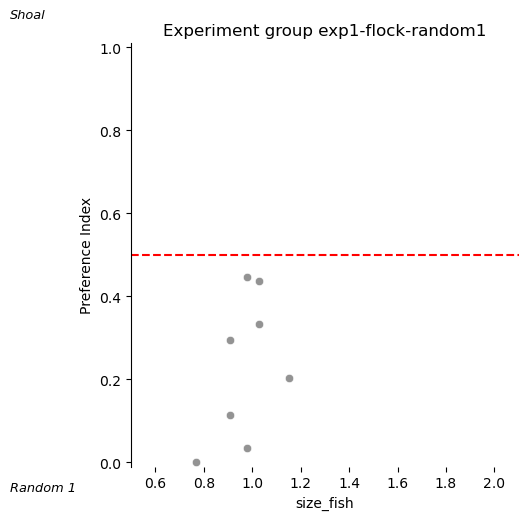

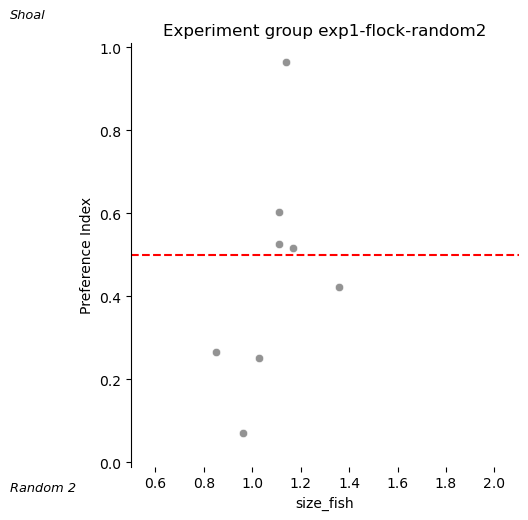

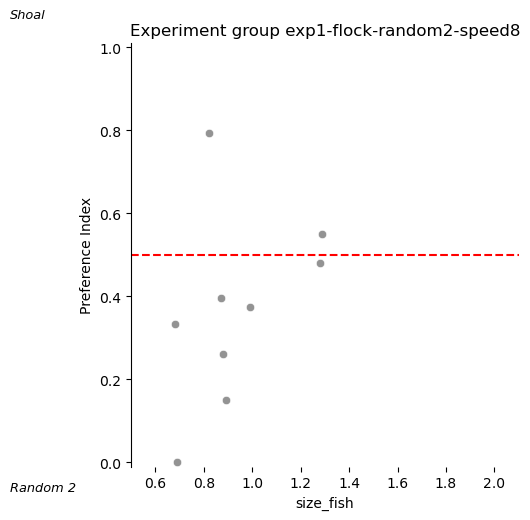

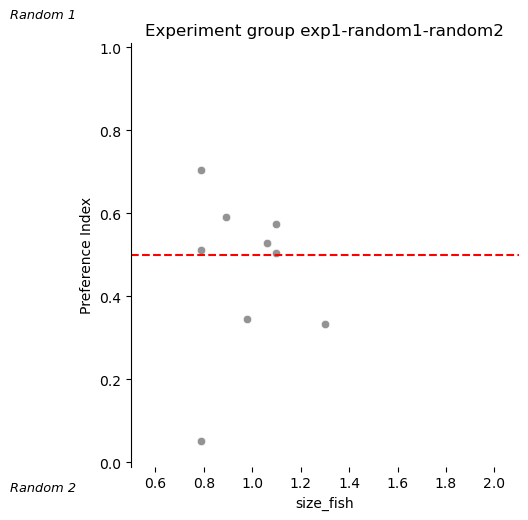

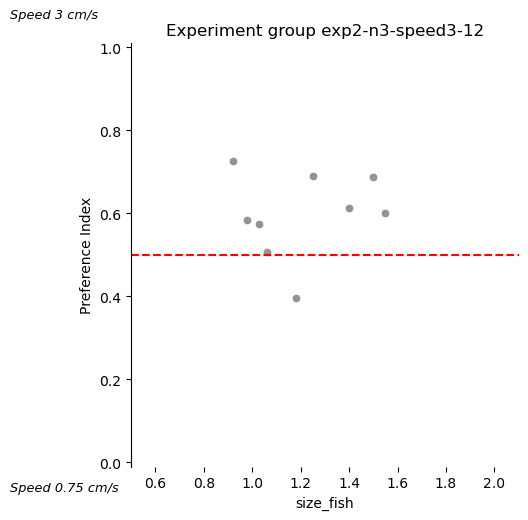

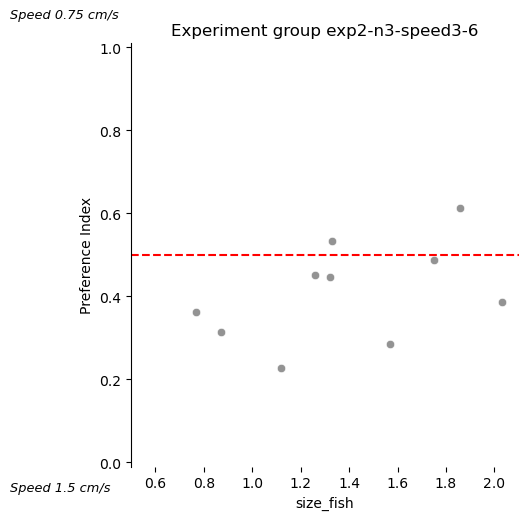

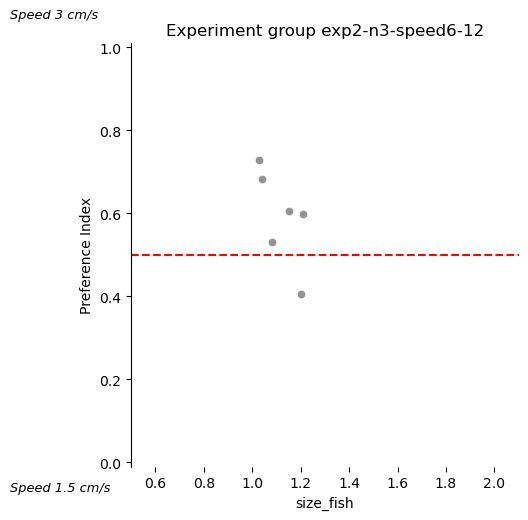

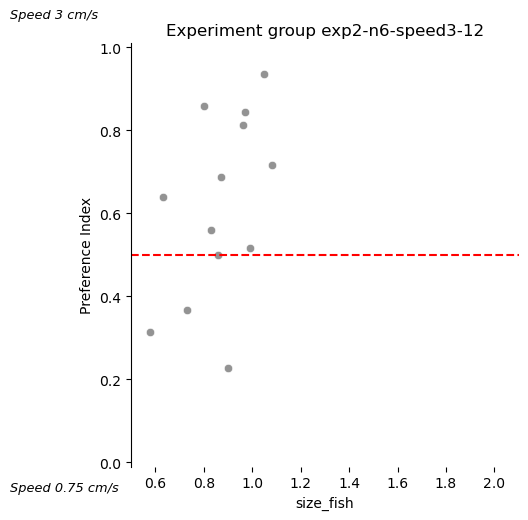

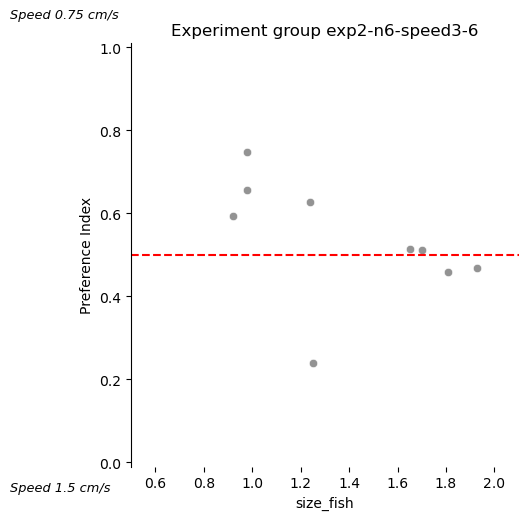

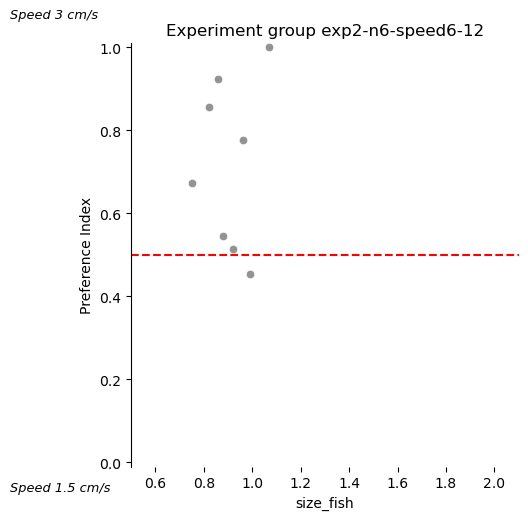

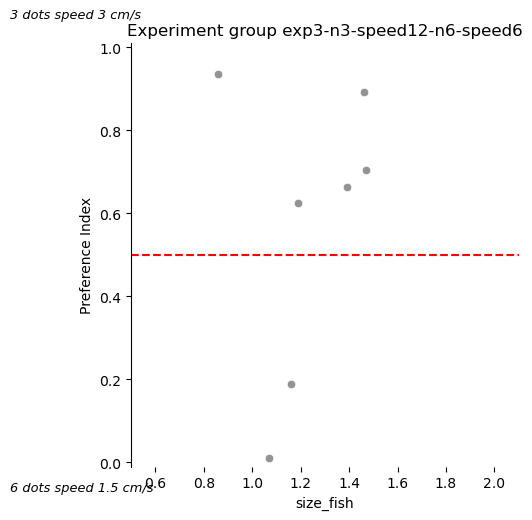

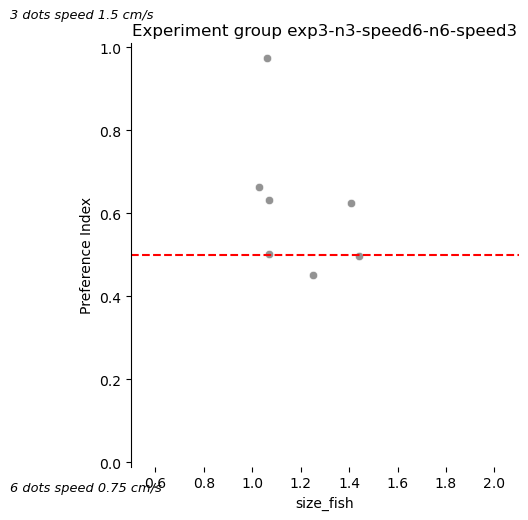

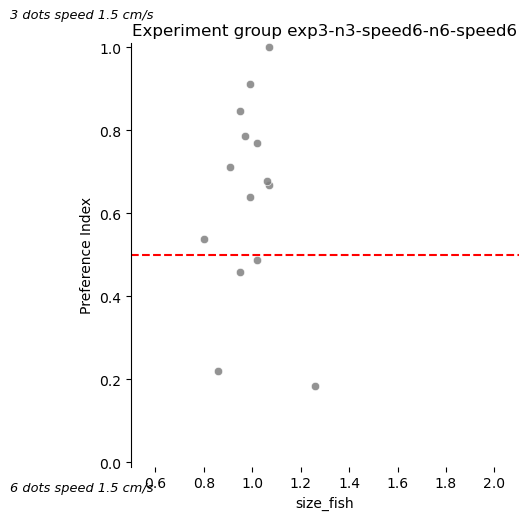

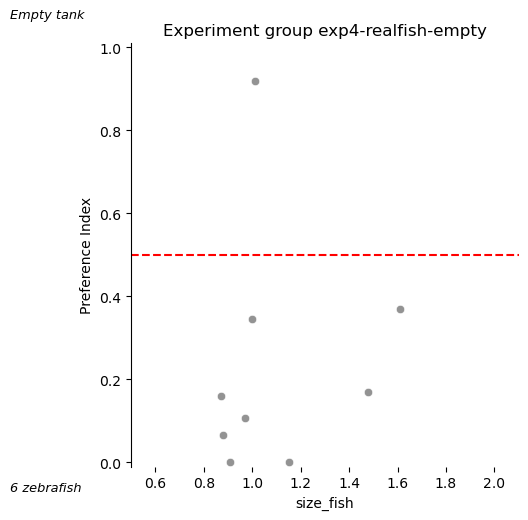

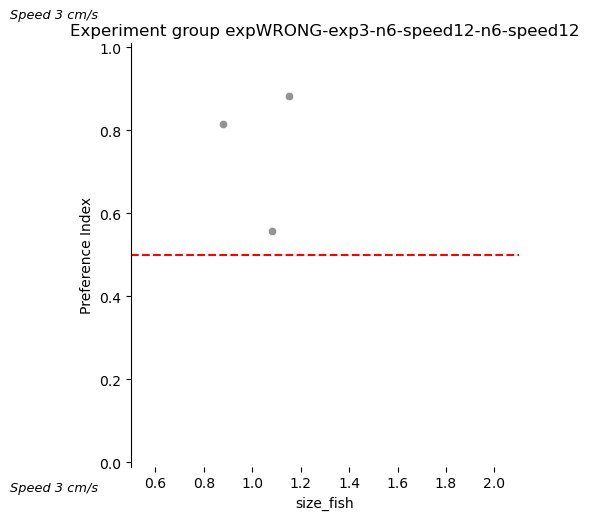

In [109]:
df_pref_idx_totsec = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

for group in exp_groups:
        bool_selector = ((df_pref_idx_totsec['fish_ID'].isin(selected_fishIDs_severity7)) & 
                         (df_pref_idx_totsec['exp_group'] == group) &
                         (df_pref_idx_totsec['date'].isin(selected_dates_severity7)) &
                         (df_pref_idx_totsec['session'] == 'TEST'))

        data_selected = df_pref_idx_totsec[bool_selector]
        data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
        fish_IDs = set(data_selected['fish_ID'])
        
        for fish in fish_IDs: 
            size = df_metadata.loc[df_metadata['fish_ID'] == fish, 'fish_size_cm'].values[0]
            rows = data_selected['fish_ID'] == fish
            data_selected.loc[rows,'size_fish'] = size
        
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(5, 5.5))

        sns.scatterplot(data=data_selected, x= 'size_fish', y="pref_index", alpha=0.85, color='grey')
        
        data_dropped = data_selected.dropna(subset=['size_fish', 'pref_index'])
        crr = stats.pearsonr(data_dropped['size_fish'], data_dropped['pref_index'])
        print(group)
        print(crr)
        
        sns.despine(bottom=True)
        
                # Set labels and title
        ax.set(ylabel="Preference Index", title=f"Experiment group {group}")
        
        # Set y-axis label position to top
        
        exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
        exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n3-speed6'] = 'Speed 1.5 cm/s'
        
        stim1 = label_dict[data_selected["stim1"].values[0]]
        stim2 = label_dict[data_selected["stim2"].values[0]]
        
        if group in exp1:
            x_text = 0
        else:
            x_text = 0
                
        ax.text(x_text, 1.07, f'{stim1}', fontsize=9.3, fontstyle='italic')
        ax.text(x_text, -0.07, f'{stim2}', fontsize=9.3, fontstyle='italic')
        
        # Draw a horizontal line at y = 0.5
        ax.axhline(y=0.5, color='red', linestyle='--', label='Threshold')
        plt.ylim(-0.01, 1.01)
        plt.xlim(0.5, 2.1)

In [123]:
## CHECK how many fish were bigger or smaller than normal 

for group in exp_groups:
    bool_selector = ((df_pref_idx_totsec['fish_ID'].isin(selected_fishIDs_severity7)) & 
                             (df_pref_idx_totsec['exp_group'] == group) &
                             (df_pref_idx_totsec['date'].isin(selected_dates_severity7)) &
                             (df_pref_idx_totsec['session'] == 'TEST'))

    data_selected = df_pref_idx_totsec[bool_selector]
    data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
    fish_IDs = set(data_selected['fish_ID'])

    for fish in fish_IDs: 
        size = df_metadata.loc[df_metadata['fish_ID'] == fish, 'fish_size_cm'].values[0]
        rows = data_selected['fish_ID'] == fish
        data_selected.loc[rows,'size_fish'] = size

    big = sum(data_selected['size_fish'] > 1.6)
    small = sum(data_selected['size_fish'] < 0.8)

    print(group)
    print('n of fish > 1.6 cm', big)
    print('n of fish < 0.8 cm', small)

exp1-flock-random1
n of fish > 1.6 cm 0
n of fish < 0.8 cm 1
exp1-flock-random2
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp1-flock-random2-speed8
n of fish > 1.6 cm 0
n of fish < 0.8 cm 2
exp1-random1-random2
n of fish > 1.6 cm 0
n of fish < 0.8 cm 3
exp2-n3-speed3-12
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp2-n3-speed3-6
n of fish > 1.6 cm 3
n of fish < 0.8 cm 1
exp2-n3-speed6-12
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp2-n6-speed3-12
n of fish > 1.6 cm 0
n of fish < 0.8 cm 3
exp2-n6-speed3-6
n of fish > 1.6 cm 4
n of fish < 0.8 cm 0
exp2-n6-speed6-12
n of fish > 1.6 cm 0
n of fish < 0.8 cm 1
exp3-n3-speed12-n6-speed6
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp3-n3-speed6-n6-speed3
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp3-n3-speed6-n6-speed6
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0
exp4-realfish-empty
n of fish > 1.6 cm 1
n of fish < 0.8 cm 0
expWRONG-exp3-n6-speed12-n6-speed12
n of fish > 1.6 cm 0
n of fish < 0.8 cm 0


C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\2804795872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\2804795872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'size_fish'] = [np.nan] * data_selected.shape[0]
C:\Users\matilde.perrino\AppData\Local\Temp\ipykernel_7724\2804795872.py:10: SettingWithCopyWarning: 
A value is trying to be 

### Plots for checking side bias

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')) &
            (df_metadata['first_exp'] == 'yes') & (df_metadata['exp_name'] == 'biodi') &
            (df_metadata['session'] == 'TEST'))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group'])))
fish_ids = list(set(df_data['fish_ID'].values))
#exp_date = list(sorted(set(df_data['date'].values)))

In [ ]:
#Dates for checking side bias across each experiment date
dates = []
for val in df_data['date'].values:
    year, month, day, hour = val.split('-')
    date = '-'.join([year, month, day])
    dates.append(date)
    
dates_set = list(sorted(set(dates)))

#### Barplot time spent near each side - grouped per experimental day

In [ ]:
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")

# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}")
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#Barplot for side bias
for date in dates_set:
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')
        
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]

        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        
        # Create the bar plot with custom edge colors
        barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'], errorbar="se", capsize=0, errwidth=1.3, width=0.6,
                              linewidth=1.5, alpha=0.5, dodge=False)
        
        #for fish_id in exp_tot_time['fish_ID'].unique():
            #data = exp_tot_time[exp_tot_time['fish_ID'] == fish_id]
            #sides = ['L', 'R']
            #ax.plot(data[data['side'] == 'L']['tot_sec'],  data[data['side'] == 'R']['tot_sec'], 
            #linewidth = 0.5, linestyle = '--')
            
        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], 
                           bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_barplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')
        
        plt.show()

#### Boxplot time spent near each side - grouped per experimental day

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")
folder_path.mkdir(parents=True, exist_ok=True)

for date in dates_set: 
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')  
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
    
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], width=0.65,
                              hue_order=['L', 'R'], dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3})

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

#### Boxplot time spent near each side - grouped per experimental group

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/exp_groups")
folder_path.mkdir(parents=True, exist_ok=True)

for group in exp_groups:
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['exp_group'] == group) & 
                     (df_data['session'] == 'HAB'))
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
        
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'],dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3}, 
                              width=0.65)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment group {group}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{group}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

#### Barplot overall total time spent near left and right

In [ ]:
bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['session'] == 'HAB')
exp_tot_time = df_data[bool_selector]

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/barplots/")
folder_path.mkdir(parents=True, exist_ok=True)

f, ax = plt.subplots(figsize=(3, 4.3))

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'],hue_order=['L', 'R'],
                      errorbar="se", capsize=0, errwidth=1.3, linewidth=1.5, alpha=0.5, dodge=False)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

#file_name = folder_path / f"sidebias_barplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

#### Boxplot overall total time spent near left and right

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")

f, ax = plt.subplots(figsize=(3, 4.3))
# Create the swarm plot

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], dodge=False, 
                          boxprops={'edgecolor': 'None', 'alpha' : 0.3}, hue_order=['L', 'R'])

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen Side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

# Show the plot

#file_name = folder_path / f"sidebias_boxplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

#### T-test with preference index

In [456]:
df_pref_stat = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

bool_selector = ((df_pref_stat['fish_ID'].isin(selected_fishIDs_severity7)) & 
                 (df_pref_stat['date'].isin(selected_dates_severity7)) &
                 (df_pref_stat['session'] == 'TEST'))
            
data_selected = df_pref_stat[bool_selector].copy()

In [457]:
pref_idx_one_asterics = []
pref_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected[data_selected['exp_group'] == group]
    t_test = stats.ttest_1samp(grouped_data['pref_index'], 0.5, nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        pref_idx_two_asterics.append(group)
    elif t_test[1] < 0.05:
        pref_idx_one_asterics.append(group)

exp1-flock-random1
TtestResult(statistic=-4.356990342748809, pvalue=0.0033263680635242, df=7)
exp1-flock-random2
TtestResult(statistic=-0.4966867134404839, pvalue=0.6346262333051718, df=7)
exp1-flock-random2-speed8
TtestResult(statistic=-1.6897069344952034, pvalue=0.12955442833018377, df=8)
exp1-random1-random2
TtestResult(statistic=-0.6197553496665682, pvalue=0.5526572051866347, df=8)
exp2-n3-speed3-12
TtestResult(statistic=2.8820696466256956, pvalue=0.020446477389779557, df=8)
exp2-n3-speed3-6
TtestResult(statistic=-2.3905157089677163, pvalue=0.04052311480378138, df=9)
exp2-n3-speed6-12
TtestResult(statistic=1.964724247281439, pvalue=0.10664133121199197, df=5)
exp2-n6-speed3-12
TtestResult(statistic=1.837980636824334, pvalue=0.09093606116302647, df=12)
exp2-n6-speed3-6
TtestResult(statistic=0.7264320004581801, pvalue=0.48828094991550075, df=8)
exp2-n6-speed6-12
TtestResult(statistic=3.0273727862726267, pvalue=0.01918558883773493, df=7)
exp3-n3-speed12-n6-speed6
TtestResult(statistic=

In [ ]:
pref_idx_one_asterics = ['exp2-n3-speed3-12', 'exp2-n6-speed6-12', 'exp4-realfish-empty']
pref_idx_two_asterics = 'exp1-flock-random1'

#### T-test for total time

In [458]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']
minutes = ['minute1', 'minute2', 'minute3', 'minute4', 'minute5']

bool_selector = ((df_data['fish_ID'].isin(selected_fishIDs_severity7)) & 
                 (df_data['date'].isin(selected_dates_severity7)) &
                 (df_data['session'] == 'TEST'))

data_selected_time = df_data[bool_selector].copy()

In [459]:
tot_time_idx_one_asterics = []
tot_time_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected_time[data_selected_time['exp_group'] == group]
    stimuli = np.unique(grouped_data['stimulus'])

    bool_stim1 = grouped_data['stimulus'] == stimuli[0]
    stimulus1_data = grouped_data[bool_stim1]

    bool_stim2 = grouped_data['stimulus'] == stimuli[1]
    stimulus2_data = grouped_data[bool_stim2]
    
    
    t_test = stats.ttest_rel(stimulus1_data['tot_sec'], stimulus2_data['tot_sec'], nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        tot_time_idx_two_asterics.append(group)

    elif t_test[1] < 0.05:
        tot_time_idx_one_asterics.append(group)

exp1-flock-random1
TtestResult(statistic=-2.425437402943634, pvalue=0.045725726905420774, df=7)
exp1-flock-random2
TtestResult(statistic=0.25053799517847897, pvalue=0.8093658393425397, df=7)
exp1-flock-random2-speed8
TtestResult(statistic=-2.1094420469007913, pvalue=0.06793225831143916, df=8)
exp1-random1-random2
TtestResult(statistic=-0.9414817254679753, pvalue=0.3740142749394594, df=8)
exp2-n3-speed3-12
TtestResult(statistic=3.178810284883095, pvalue=0.013020771122004306, df=8)
exp2-n3-speed3-6
TtestResult(statistic=-2.546812507040904, pvalue=0.03135831126427355, df=9)
exp2-n3-speed6-12
TtestResult(statistic=2.1210276609653778, pvalue=0.08739171111825468, df=5)
exp2-n6-speed3-12
TtestResult(statistic=2.093066654518017, pvalue=0.05825750229742441, df=12)
exp2-n6-speed3-6
TtestResult(statistic=0.11306541172458111, pvalue=0.9127644818230747, df=8)
exp2-n6-speed6-12
TtestResult(statistic=2.519850175948755, pvalue=0.03981925880366799, df=7)
exp3-n3-speed12-n6-speed6
TtestResult(statistic=

In [ ]:
tot_time_idx_one_asterics = ['exp1-flock-random1', 'exp2-n3-speed3-12', 'exp2-n6-speed3-12',
                             'exp2-n6-speed6-12', 'exp3-n3-speed6-n6-speed6', 'exp4-realfish-empty']

#### t-test across minutes

In [ ]:
for group in exp_groups:
    grouped_data = data_selected_time[data_selected_time['exp_group'] == group]
    stimuli = np.unique(grouped_data['stimulus'])

    bool_stim1 = grouped_data['stimulus'] == stimuli[0]
    stimulus1_data = grouped_data[bool_stim1]

    bool_stim2 = grouped_data['stimulus'] == stimuli[1]
    stimulus2_data = grouped_data[bool_stim2]
    
    for minute in minutes:
        t_test = stats.ttest_rel(stimulus1_data[minute], 
                                 stimulus2_data[minute], nan_policy = 'omit')
        print(group, minute)
        print(t_test)

### Plotting results

#### Plots for side bias

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group'])))
fish_ids = list(set(df_data['fish_ID'].values))
#exp_date = list(sorted(set(df_data['date'].values)))

In [ ]:
#Dates for checking side bias across each experiment date
dates = []
for val in df_data['date'].values:
    year, month, day, hour = val.split('-')
    date = '-'.join([year, month, day])
    dates.append(date)
    
dates_set = list(sorted(set(dates)))

In [ ]:
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")

# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}")
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#Barplot for side bias
for date in dates_set:
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')
        
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]

        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        
        # Create the bar plot with custom edge colors
        barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'], errorbar="se", capsize=0, errwidth=1.3, width=0.6,
                              linewidth=1.5, alpha=0.5, dodge=False)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], 
                           bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_barplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')
        
        plt.show()

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")
folder_path.mkdir(parents=True, exist_ok=True)

for date in dates_set: 
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')  
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
    
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], width=0.65,
                              hue_order=['L', 'R'], dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3})

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/exp_groups")
folder_path.mkdir(parents=True, exist_ok=True)

for group in exp_groups:
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['exp_group'] == group) & 
                     (df_data['session'] == 'HAB'))
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
        
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'],dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3}, 
                              width=0.65)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment group {group}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{group}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

In [ ]:
bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['session'] == 'HAB')
exp_tot_time = df_data[bool_selector]

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/barplots/")
folder_path.mkdir(parents=True, exist_ok=True)

f, ax = plt.subplots(figsize=(3, 4.3))

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'],hue_order=['L', 'R'],
                      errorbar="se", capsize=0, errwidth=1.3, linewidth=1.5, alpha=0.5, dodge=False)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

#file_name = folder_path / f"sidebias_barplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")

f, ax = plt.subplots(figsize=(3, 4.3))
# Create the swarm plot

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], dodge=False, 
                          boxprops={'edgecolor': 'None', 'alpha' : 0.3}, hue_order=['L', 'R'])

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen Side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

# Show the plot

#file_name = folder_path / f"sidebias_boxplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')